In [1]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import random
import gym

%matplotlib inline

In [2]:
tf.reset_default_graph()
sess = tf.Session()

In [3]:
def copy_net(name1, name2):
    variables = tf.trainable_variables()
    for var1 in variables:
        if name2+"/" in var1.name:
            trained_var = [var2 for var2 in tf.trainable_variables() if var2.op.name in str.replace(var1.name, name2+"/", name1+"/")][0]
            value = sess.run(trained_var)
            sess.run(tf.assign(var1, value))

In [4]:
# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))

In [5]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)

        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//nproc)):
            env.step(env.action_space.sample())
        return env
    return _f

In [6]:
env_name = "MountainCar-v0"
stochastic_action_likelihood = 0.8
discount = 0.99
state_queue_size = 1
learning_rate = 0.1

iterations = 50000
batch_size = 64
update_net_period = 50
history_size = 512

nproc = 60
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy
        
# This code gets action and observation space sizes for 1D tasks
action_space_size = envs.action_space.n if isinstance(envs.action_space, gym.spaces.discrete.Discrete) else envs.action_space.shape[0]
observation_space_size = envs.observation_space.n if isinstance(envs.observation_space, gym.spaces.discrete.Discrete) else envs.observation_space.shape[0]

plots_data = {
    "reward": [],
    "loss": [],
    "gradients_max_abs": [],
    "gradients_equal_zero": [],
    "max_action": [],
    "max_qvals": [],
    "min_qvals": [],
}

In [7]:
class QualityNet:
    def __init__(self, net_name):
        with tf.variable_scope(net_name + "/"):
            layers_config = (action_space_size + state_queue_size*observation_space_size, 32) # 32 - hidden layer size

            self.input_state = tf.placeholder(tf.float32, shape=[None, state_queue_size, observation_space_size], name="input_state")
            self.flattened_state = tf.reshape(self.input_state, [-1, observation_space_size * state_queue_size])
            self.input_action = tf.placeholder(tf.int32, shape=[None], name="input_action")
            input_action_one_hot = tf.one_hot(self.input_action, depth=action_space_size)
            
            self.input_data = tf.concat([self.flattened_state, input_action_one_hot], 1)
            
            self.input_layer = tf.layers.dense(self.input_data, units=layers_config[0], activation='relu')
            self.hidden_layer = tf.layers.dense(self.input_layer, units=layers_config[1], activation='relu')
            self.output_layer = tf.layers.dense(self.hidden_layer, units=1)
            
            self.exp_value = tf.placeholder(tf.float32, name="exp_value") #  shape=[None] WTF???
            self.loss = tf.losses.mean_squared_error(self.exp_value, self.output_layer)
            
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if "train_net/" in t_var.name]) # For Debug!
            
            optimizer = tf.train.AdamOptimizer(learning_rate)
            self.train_op = optimizer.minimize(self.loss)
            
            var_ph = tf.placeholder()
            assign_op = [tf.assign(var, ph) for var in []]

prediction_net = QualityNet("prediction_net")
train_net = QualityNet("train_net")     

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

W0717 11:07:53.903741 15132 deprecation.py:323] From <ipython-input-7-905193551775>:13: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0717 11:07:53.911690 15132 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0717 11:07:54.233860 15132 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
def prepare_input(states_q):
    return np.repeat(np.array(states_q), repeats=action_space_size, axis=0), np.tile(range(action_space_size), len(states_q))

In [9]:
prepare_input([[2,1],[3,1],[4,1],[5,1]])

(array([[2, 1],
        [2, 1],
        [2, 1],
        [3, 1],
        [3, 1],
        [3, 1],
        [4, 1],
        [4, 1],
        [4, 1],
        [5, 1],
        [5, 1],
        [5, 1]]), array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]))

In [10]:
np.reshape([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4], (4, 3))

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4]])

In [11]:
def update_state(state_queue, val):
    state_queue.pop()
    state_queue.insert(0, val)
a = [[1, 1], [2, 2], [3, 3]]
update_state(a, [4, 4])
a

[[4, 4], [1, 1], [2, 2]]

In [16]:
def batch_generator(batch_size, history_size):
    """
        history[0] = queue of four last states
        history[1] = action
        history[2] = reward
        history[3] = states queue with new state
        history[4] = discounted reward
    """
    states_q = [[np.random.sample(observation_space_size) for _ in range(state_queue_size)] for _ in range(nproc)] #observation_space_size refactor
    trajectories = [np.empty((0, 4)) for _ in range(nproc)]

    history = np.empty((0, 5))
    observations = [[0 for i in range(observation_space_size)] for j in range(nproc)] #envs.reset()
    for pid in range(nproc):
        update_state(states_q[pid], observations[pid])

    while True:
        history = history[batch_size:]
        while len(history) < history_size:
            if random.random() < stochastic_action_likelihood:
                actions = np.stack([envs.action_space.sample() for _ in range(nproc)]) # test
            else:
                ############ action prediction ############
                input_states, input_actions = prepare_input(states_q)
                #print(states_q)
                qvalues = sess.run((prediction_net.output_layer), feed_dict={
                        prediction_net.input_state: input_states,
                        prediction_net.input_action: input_actions,
                    })
                qvalues = qvalues.reshape(len(qvalues) // action_space_size, action_space_size) ##???????????
                
                print(qvalues)
                
                plots_data["max_qvals"].append(qvalues.max(axis=1)[0])
                plots_data["min_qvals"].append(qvalues.min(axis=1)[0])
                actions = np.argmax(qvalues, axis=1)
                ###########################################
            observations, rewards, dones, _ = envs.step(actions)
            rewards /= 50

            for pid in range(nproc):
                new_state = copy.deepcopy(states_q[pid])
                update_state(new_state, observations[pid])

                update_state(states_q[pid], observations[pid])### DEAD BUG

                trajectories[pid] = np.vstack((trajectories[pid], [states_q[pid], actions[pid], rewards[pid], new_state]))

                if dones[pid]:
                    ################ qvalues prediction ################
                    input_states, input_actions = prepare_input(trajectories[pid][:-1][:, 3])
                    qvalues = sess.run((prediction_net.output_layer), feed_dict={
                            prediction_net.input_state: np.array(input_states.tolist()),
                            prediction_net.input_action: input_actions,
                        })
                    qvalues = qvalues.reshape(len(qvalues) // action_space_size, action_space_size).max(axis=1)
                    qvalues *= discount
                    qvalues = qvalues + trajectories[pid][:-1][:, 2]
                    qvalues = np.append(qvalues, rewards[pid])
                    ####################################################

                    new_history = np.hstack((trajectories[pid], np.expand_dims(qvalues, axis=-1)))   
                    plots_data["reward"].append((trajectories[pid][:, 2].sum())*50)
                    trajectories[pid] = np.empty((0, 4))
                    history = np.vstack((history, new_history))

        np.random.shuffle(history)
        history = history[:history_size]
        yield history[:batch_size]

In [17]:
batch_gen = batch_generator(batch_size, history_size)
next(batch_gen)
next(batch_gen)
next(batch_gen)

[[-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742 -0.26905394]
 [-0.05731539 -0.05565742

[array([-0.56570137,  0.00305354], dtype=float32)]
[[0, 0]]
[array([-0.56570137,  0.00305354], dtype=float32)]
----38----
[-0.6417916  -0.01541648]
[[0, 0]]
[array([-0.6417916 , -0.01541648], dtype=float32)]
[[0, 0]]
[array([-0.6417916 , -0.01541648], dtype=float32)]
----39----
[-0.5589393  -0.00540406]
[[0, 0]]
[array([-0.5589393 , -0.00540406], dtype=float32)]
[[0, 0]]
[array([-0.5589393 , -0.00540406], dtype=float32)]
----40----
[-0.58148164  0.00677026]
[[0, 0]]
[array([-0.58148164,  0.00677026], dtype=float32)]
[[0, 0]]
[array([-0.58148164,  0.00677026], dtype=float32)]
----41----
[-0.46709558  0.00631245]
[[0, 0]]
[array([-0.46709558,  0.00631245], dtype=float32)]
[[0, 0]]
[array([-0.46709558,  0.00631245], dtype=float32)]
----42----
[-0.4397703   0.00133364]
[[0, 0]]
[array([-0.4397703 ,  0.00133364], dtype=float32)]
[[0, 0]]
[array([-0.4397703 ,  0.00133364], dtype=float32)]
----43----
[-0.42011496 -0.00344588]
[[0, 0]]
[array([-0.42011496, -0.00344588], dtype=float32)]
[[0, 0]

[array([-0.6168258 ,  0.00178191], dtype=float32)]
[array([-0.6186077 ,  0.00107895], dtype=float32)]
[array([-0.6168258 ,  0.00178191], dtype=float32)]
----10----
[-0.49728343  0.00633619]
[array([-0.5036196 ,  0.00648595], dtype=float32)]
[array([-0.49728343,  0.00633619], dtype=float32)]
[array([-0.5036196 ,  0.00648595], dtype=float32)]
[array([-0.49728343,  0.00633619], dtype=float32)]
----11----
[-0.56510556 -0.00247008]
[array([-0.5626355 , -0.00276218], dtype=float32)]
[array([-0.56510556, -0.00247008], dtype=float32)]
[array([-0.5626355 , -0.00276218], dtype=float32)]
[array([-0.56510556, -0.00247008], dtype=float32)]
----12----
[-0.5490382  -0.00159604]
[array([-0.54744214, -0.00177471], dtype=float32)]
[array([-0.5490382 , -0.00159604], dtype=float32)]
[array([-0.54744214, -0.00177471], dtype=float32)]
[array([-0.5490382 , -0.00159604], dtype=float32)]
----13----
[-0.4719995   0.00766621]
[array([-0.4796657 ,  0.00799476], dtype=float32)]
[array([-0.4719995 ,  0.00766621], d

[array([-0.42011496, -0.00344588], dtype=float32)]
[array([-0.42432457, -0.00420961], dtype=float32)]
[array([-0.42011496, -0.00344588], dtype=float32)]
[array([-0.42432457, -0.00420961], dtype=float32)]
----44----
[-0.5895349   0.00372327]
[array([-0.59325814,  0.00320462], dtype=float32)]
[array([-0.5895349 ,  0.00372327], dtype=float32)]
[array([-0.59325814,  0.00320462], dtype=float32)]
[array([-0.5895349 ,  0.00372327], dtype=float32)]
----45----
[-0.5563535  -0.00315666]
[array([-0.55319685, -0.00337835], dtype=float32)]
[array([-0.5563535 , -0.00315666], dtype=float32)]
[array([-0.55319685, -0.00337835], dtype=float32)]
[array([-0.5563535 , -0.00315666], dtype=float32)]
----46----
[-0.41887054 -0.00559636]
[array([-0.41327417, -0.00478395], dtype=float32)]
[array([-0.41887054, -0.00559636], dtype=float32)]
[array([-0.41327417, -0.00478395], dtype=float32)]
[array([-0.41887054, -0.00559636], dtype=float32)]
----47----
[-0.47939363  0.00343283]
[array([-0.48282647,  0.00373786], d

----17----
[-0.49560884  0.0036051 ]
[array([-0.49921393,  0.00378783], dtype=float32)]
[array([-0.49560884,  0.0036051 ], dtype=float32)]
[array([-0.49921393,  0.00378783], dtype=float32)]
[array([-0.49560884,  0.0036051 ], dtype=float32)]
----18----
[-0.5536812  -0.00358026]
[array([-0.5501009 , -0.00477882], dtype=float32)]
[array([-0.5536812 , -0.00358026], dtype=float32)]
[array([-0.5501009 , -0.00477882], dtype=float32)]
[array([-0.5536812 , -0.00358026], dtype=float32)]
----19----
[-0.36957026  0.00062782]
[array([-0.37019807,  0.00273814], dtype=float32)]
[array([-0.36957026,  0.00062782], dtype=float32)]
[array([-0.37019807,  0.00273814], dtype=float32)]
[array([-0.36957026,  0.00062782], dtype=float32)]
----20----
[-0.49230742 -0.00250307]
[array([-0.48980436, -0.00225005], dtype=float32)]
[array([-0.49230742, -0.00250307], dtype=float32)]
[array([-0.48980436, -0.00225005], dtype=float32)]
[array([-0.49230742, -0.00250307], dtype=float32)]
----21----
[-0.57909185  0.00239422]

[array([-0.6170504 , -0.00613317], dtype=float32)]
----51----
[-0.65410125  0.00122381]
[array([-0.6553251 ,  0.00126138], dtype=float32)]
[array([-0.65410125,  0.00122381], dtype=float32)]
[array([-0.6553251 ,  0.00126138], dtype=float32)]
[array([-0.65410125,  0.00122381], dtype=float32)]
----52----
[-0.6335322   0.00081711]
[array([-0.6343493 , -0.00099833], dtype=float32)]
[array([-0.6335322 ,  0.00081711], dtype=float32)]
[array([-0.6343493 , -0.00099833], dtype=float32)]
[array([-0.6335322 ,  0.00081711], dtype=float32)]
----53----
[-0.49944043 -0.00673787]
[array([-0.49270257, -0.00550648], dtype=float32)]
[array([-0.49944043, -0.00673787], dtype=float32)]
[array([-0.49270257, -0.00550648], dtype=float32)]
[array([-0.49944043, -0.00673787], dtype=float32)]
----54----
[-6.6637754e-01 -2.9567594e-04]
[array([-0.66608185, -0.00233205], dtype=float32)]
[array([-6.6637754e-01, -2.9567594e-04], dtype=float32)]
[array([-0.66608185, -0.00233205], dtype=float32)]
[array([-6.6637754e-01, 

[array([-0.66244006,  0.00822804], dtype=float32)]
----25----
[-0.49741095 -0.00551545]
[array([-0.4918955 , -0.00427803], dtype=float32)]
[array([-0.49741095, -0.00551545], dtype=float32)]
[array([-0.4918955 , -0.00427803], dtype=float32)]
[array([-0.49741095, -0.00551545], dtype=float32)]
----26----
[-0.67220676 -0.0048858 ]
[array([-0.66732097, -0.00493063], dtype=float32)]
[array([-0.67220676, -0.0048858 ], dtype=float32)]
[array([-0.66732097, -0.00493063], dtype=float32)]
[array([-0.67220676, -0.0048858 ], dtype=float32)]
----27----
[-0.60537165 -0.00176916]
[array([-0.60360247, -0.00136344], dtype=float32)]
[array([-0.60537165, -0.00176916], dtype=float32)]
[array([-0.60360247, -0.00136344], dtype=float32)]
[array([-0.60537165, -0.00176916], dtype=float32)]
----28----
[-0.7696915  -0.00651424]
[array([-0.76317734, -0.00716032], dtype=float32)]
[array([-0.7696915 , -0.00651424], dtype=float32)]
[array([-0.76317734, -0.00716032], dtype=float32)]
[array([-0.7696915 , -0.00651424], d

[array([-0.4289036, -0.0046817], dtype=float32)]
[array([-0.434286 , -0.0053824], dtype=float32)]
----59----
[-0.4809417  -0.00130843]
[array([-0.4796333 , -0.00197964], dtype=float32)]
[array([-0.4809417 , -0.00130843], dtype=float32)]
[array([-0.4796333 , -0.00197964], dtype=float32)]
[array([-0.4809417 , -0.00130843], dtype=float32)]
----0----
[-0.5494677   0.00605005]
[array([-0.55551773,  0.00481102], dtype=float32)]
[array([-0.5494677 ,  0.00605005], dtype=float32)]
[array([-0.55551773,  0.00481102], dtype=float32)]
[array([-0.5494677 ,  0.00605005], dtype=float32)]
----1----
[-0.5599264 -0.0109512]
[array([-0.54897517, -0.01014134], dtype=float32)]
[array([-0.5599264, -0.0109512], dtype=float32)]
[array([-0.54897517, -0.01014134], dtype=float32)]
[array([-0.5599264, -0.0109512], dtype=float32)]
----2----
[-0.5306324 -0.0081118]
[array([-0.5225206 , -0.00710371], dtype=float32)]
[array([-0.5306324, -0.0081118], dtype=float32)]
[array([-0.5225206 , -0.00710371], dtype=float32)]
[a

[array([-0.5891211, -0.0156893], dtype=float32)]
[array([-0.6053221 , -0.01620104], dtype=float32)]
----33----
[-0.47524938 -0.00773191]
[array([-0.46751747, -0.00631329], dtype=float32)]
[array([-0.47524938, -0.00773191], dtype=float32)]
[array([-0.46751747, -0.00631329], dtype=float32)]
[array([-0.47524938, -0.00773191], dtype=float32)]
----34----
[-0.5018303   0.00213624]
[array([-0.5039665 ,  0.00328339], dtype=float32)]
[array([-0.5018303 ,  0.00213624], dtype=float32)]
[array([-0.5039665 ,  0.00328339], dtype=float32)]
[array([-0.5018303 ,  0.00213624], dtype=float32)]
----35----
[-0.4400884   0.00557904]
[array([-0.44566745,  0.00615822], dtype=float32)]
[array([-0.4400884 ,  0.00557904], dtype=float32)]
[array([-0.44566745,  0.00615822], dtype=float32)]
[array([-0.4400884 ,  0.00557904], dtype=float32)]
----36----
[-0.4737871   0.00704275]
[array([-0.48082983,  0.00736264], dtype=float32)]
[array([-0.4737871 ,  0.00704275], dtype=float32)]
[array([-0.48082983,  0.00736264], dty

[array([-0.525374  ,  0.00522784], dtype=float32)]
[array([-0.53060186,  0.00417532], dtype=float32)]
[array([-0.525374  ,  0.00522784], dtype=float32)]
----7----
[-0.5220643   0.00718093]
[array([-0.52924526,  0.00713858], dtype=float32)]
[array([-0.5220643 ,  0.00718093], dtype=float32)]
[array([-0.52924526,  0.00713858], dtype=float32)]
[array([-0.5220643 ,  0.00718093], dtype=float32)]
----8----
[-0.54946953  0.00540356]
[array([-0.55487305,  0.00416935], dtype=float32)]
[array([-0.54946953,  0.00540356], dtype=float32)]
[array([-0.55487305,  0.00416935], dtype=float32)]
[array([-0.54946953,  0.00540356], dtype=float32)]
----9----
[-0.60005015  0.00538708]
[array([-0.6054372 ,  0.00477944], dtype=float32)]
[array([-0.60005015,  0.00538708], dtype=float32)]
[array([-0.6054372 ,  0.00477944], dtype=float32)]
[array([-0.60005015,  0.00538708], dtype=float32)]
----10----
[-0.46839622  0.00825059]
[array([-0.4766468 ,  0.00760157], dtype=float32)]
[array([-0.46839622,  0.00825059], dtyp

[-0.5412819  0.0083543]
[array([-0.5496362 ,  0.00815922], dtype=float32)]
[array([-0.5412819,  0.0083543], dtype=float32)]
[array([-0.5496362 ,  0.00815922], dtype=float32)]
[array([-0.5412819,  0.0083543], dtype=float32)]
----41----
[-0.4426522   0.00482044]
[array([-0.44747263,  0.00438643], dtype=float32)]
[array([-0.4426522 ,  0.00482044], dtype=float32)]
[array([-0.44747263,  0.00438643], dtype=float32)]
[array([-0.4426522 ,  0.00482044], dtype=float32)]
----42----
[-0.43951932 -0.00081186]
[array([-4.3870744e-01, -1.8203445e-04], dtype=float32)]
[array([-0.43951932, -0.00081186], dtype=float32)]
[array([-4.3870744e-01, -1.8203445e-04], dtype=float32)]
[array([-0.43951932, -0.00081186], dtype=float32)]
----43----
[-0.45401686 -0.00784524]
[array([-0.4461716 , -0.00826975], dtype=float32)]
[array([-0.45401686, -0.00784524], dtype=float32)]
[array([-0.4461716 , -0.00826975], dtype=float32)]
[array([-0.45401686, -0.00784524], dtype=float32)]
----44----
[-0.5680858   0.00546646]
[arr

[array([-0.4496589 ,  0.00384457], dtype=float32)]
[array([-0.44636434,  0.00329456], dtype=float32)]
----14----
[-0.5830393  -0.00180255]
[array([-0.5812367 , -0.00223269], dtype=float32)]
[array([-0.5830393 , -0.00180255], dtype=float32)]
[array([-0.5812367 , -0.00223269], dtype=float32)]
[array([-0.5830393 , -0.00180255], dtype=float32)]
----15----
[-0.47569075  0.00224739]
[array([-0.47793815,  0.00158878], dtype=float32)]
[array([-0.47569075,  0.00224739], dtype=float32)]
[array([-0.47793815,  0.00158878], dtype=float32)]
[array([-0.47569075,  0.00224739], dtype=float32)]
----16----
[-0.37159514  0.00185049]
[array([-0.37344563,  0.00393894], dtype=float32)]
[array([-0.37159514,  0.00185049], dtype=float32)]
[array([-0.37344563,  0.00393894], dtype=float32)]
[array([-0.37159514,  0.00185049], dtype=float32)]
----17----
[-0.4914182   0.00069577]
[array([-4.921140e-01, -6.844416e-05], dtype=float32)]
[array([-0.4914182 ,  0.00069577], dtype=float32)]
[array([-4.921140e-01, -6.844416

[array([-4.7608155e-01,  4.9466973e-05], dtype=float32)]
[array([-0.47738728, -0.00130571], dtype=float32)]
[array([-4.7608155e-01,  4.9466973e-05], dtype=float32)]
[array([-0.47738728, -0.00130571], dtype=float32)]
----48----
[-0.62918836  0.0077594 ]
[array([-0.63694775,  0.00692558], dtype=float32)]
[array([-0.62918836,  0.0077594 ], dtype=float32)]
[array([-0.63694775,  0.00692558], dtype=float32)]
[array([-0.62918836,  0.0077594 ], dtype=float32)]
----49----
[-4.8088017e-01 -1.2679010e-04]
[array([-0.48075336,  0.00119367], dtype=float32)]
[array([-4.8088017e-01, -1.2679010e-04], dtype=float32)]
[array([-0.48075336,  0.00119367], dtype=float32)]
[array([-4.8088017e-01, -1.2679010e-04], dtype=float32)]
----50----
[-0.63723063 -0.0031108 ]
[array([-0.63411987, -0.0049246 ], dtype=float32)]
[array([-0.63723063, -0.0031108 ], dtype=float32)]
[array([-0.63411987, -0.0049246 ], dtype=float32)]
[array([-0.63723063, -0.0031108 ], dtype=float32)]
----51----
[-0.6369201   0.00488092]
[array

[array([-0.5107871 , -0.00440339], dtype=float32)]
----21----
[-0.55159444  0.00610376]
[array([-0.5576982 ,  0.00684846], dtype=float32)]
[array([-0.55159444,  0.00610376], dtype=float32)]
[array([-0.5576982 ,  0.00684846], dtype=float32)]
[array([-0.55159444,  0.00610376], dtype=float32)]
----22----
[-0.57148933 -0.00079519]
[array([-0.57069415, -0.00214723], dtype=float32)]
[array([-0.57148933, -0.00079519], dtype=float32)]
[array([-0.57069415, -0.00214723], dtype=float32)]
[array([-0.57148933, -0.00079519], dtype=float32)]
----23----
[-0.5548981   0.00458371]
[array([-0.5594818 ,  0.00331511], dtype=float32)]
[array([-0.5548981 ,  0.00458371], dtype=float32)]
[array([-0.5594818 ,  0.00331511], dtype=float32)]
[array([-0.5548981 ,  0.00458371], dtype=float32)]
----24----
[-0.6180528   0.01387594]
[array([-0.63192874,  0.01207769], dtype=float32)]
[array([-0.6180528 ,  0.01387594], dtype=float32)]
[array([-0.63192874,  0.01207769], dtype=float32)]
[array([-0.6180528 ,  0.01387594], d

[array([-0.65735126,  0.00384297], dtype=float32)]
[array([-0.6611942 ,  0.00284006], dtype=float32)]
[array([-0.65735126,  0.00384297], dtype=float32)]
----55----
[-0.5540598 -0.0005579]
[array([-0.5535019 , -0.00078187], dtype=float32)]
[array([-0.5540598, -0.0005579], dtype=float32)]
[array([-0.5535019 , -0.00078187], dtype=float32)]
[array([-0.5540598, -0.0005579], dtype=float32)]
----56----
[-0.42133194 -0.00306019]
[array([-0.41827175, -0.00328332], dtype=float32)]
[array([-0.42133194, -0.00306019], dtype=float32)]
[array([-0.41827175, -0.00328332], dtype=float32)]
[array([-0.42133194, -0.00306019], dtype=float32)]
----57----
[-0.4876624  -0.00204469]
[array([-0.4856177 , -0.00276044], dtype=float32)]
[array([-0.4876624 , -0.00204469], dtype=float32)]
[array([-0.4856177 , -0.00276044], dtype=float32)]
[array([-0.4876624 , -0.00204469], dtype=float32)]
----58----
[-0.46594346 -0.00972642]
[array([-0.45621705, -0.00822449], dtype=float32)]
[array([-0.46594346, -0.00972642], dtype=f

[-0.77767324  0.00105865]
[array([-7.7873188e-01,  3.2659026e-04], dtype=float32)]
[array([-0.77767324,  0.00105865], dtype=float32)]
[array([-7.7873188e-01,  3.2659026e-04], dtype=float32)]
[array([-0.77767324,  0.00105865], dtype=float32)]
----29----
[-0.54329085 -0.01638076]
[array([-0.5269101 , -0.01640559], dtype=float32)]
[array([-0.54329085, -0.01638076], dtype=float32)]
[array([-0.5269101 , -0.01640559], dtype=float32)]
[array([-0.54329085, -0.01638076], dtype=float32)]
----30----
[-0.5068987   0.00188943]
[array([-0.50878817,  0.00100048], dtype=float32)]
[array([-0.5068987 ,  0.00188943], dtype=float32)]
[array([-0.50878817,  0.00100048], dtype=float32)]
[array([-0.5068987 ,  0.00188943], dtype=float32)]
----31----
[-0.574889   -0.00179362]
[array([-0.5730954 , -0.00216348], dtype=float32)]
[array([-0.574889  , -0.00179362], dtype=float32)]
[array([-0.5730954 , -0.00216348], dtype=float32)]
[array([-0.574889  , -0.00179362], dtype=float32)]
----32----
[-0.66888744 -0.01507581

 [-0.08875886 -0.0316188  -0.14621097]]
----0----
[-0.5191924   0.00657951]
[array([-0.5257719 ,  0.00656321], dtype=float32)]
[array([-0.5191924 ,  0.00657951], dtype=float32)]
[array([-0.5257719 ,  0.00656321], dtype=float32)]
[array([-0.5191924 ,  0.00657951], dtype=float32)]
----1----
[-0.60799646 -0.00780784]
[array([-0.6001886 , -0.00837722], dtype=float32)]
[array([-0.60799646, -0.00780784], dtype=float32)]
[array([-0.6001886 , -0.00837722], dtype=float32)]
[array([-0.60799646, -0.00780784], dtype=float32)]
----2----
[-0.5759935  -0.00814467]
[array([-0.5678488 , -0.00847557], dtype=float32)]
[array([-0.5759935 , -0.00814467], dtype=float32)]
[array([-0.5678488 , -0.00847557], dtype=float32)]
[array([-0.5759935 , -0.00814467], dtype=float32)]
----3----
[-0.58417016 -0.00086588]
[array([-0.5833043 , -0.00131128], dtype=float32)]
[array([-0.58417016, -0.00086588], dtype=float32)]
[array([-0.5833043 , -0.00131128], dtype=float32)]
[array([-0.58417016, -0.00086588], dtype=float32)]


[array([-0.5151224 , -0.00793766], dtype=float32)]
[array([-0.50718474, -0.00781461], dtype=float32)]
[array([-0.5151224 , -0.00793766], dtype=float32)]
----34----
[-4.9774492e-01  2.4575464e-04]
[array([-4.9799067e-01,  4.3762653e-04], dtype=float32)]
[array([-4.9774492e-01,  2.4575464e-04], dtype=float32)]
[array([-4.9799067e-01,  4.3762653e-04], dtype=float32)]
[array([-4.9774492e-01,  2.4575464e-04], dtype=float32)]
----35----
[-0.41629946  0.00308472]
[array([-0.41938418,  0.00385366], dtype=float32)]
[array([-0.41629946,  0.00308472], dtype=float32)]
[array([-0.41938418,  0.00385366], dtype=float32)]
[array([-0.41629946,  0.00308472], dtype=float32)]
----36----
[-0.43334106  0.00758418]
[array([-0.44092524,  0.0081979 ], dtype=float32)]
[array([-0.43334106,  0.00758418], dtype=float32)]
[array([-0.44092524,  0.0081979 ], dtype=float32)]
[array([-0.43334106,  0.00758418], dtype=float32)]
----37----
[-0.51160955  0.00642019]
[array([-0.51802975,  0.00646196], dtype=float32)]
[array

[-0.49420404  0.00468927]
[array([-0.49889332,  0.00587439], dtype=float32)]
[array([-0.49420404,  0.00468927], dtype=float32)]
[array([-0.49889332,  0.00587439], dtype=float32)]
[array([-0.49420404,  0.00468927], dtype=float32)]
----8----
[-0.5262929   0.00501094]
[array([-0.5313039 ,  0.00395316], dtype=float32)]
[array([-0.5262929 ,  0.00501094], dtype=float32)]
[array([-0.5313039 ,  0.00395316], dtype=float32)]
[array([-0.5262929 ,  0.00501094], dtype=float32)]
----9----
[-0.5645922   0.00772548]
[array([-0.57231766,  0.00736139], dtype=float32)]
[array([-0.5645922 ,  0.00772548], dtype=float32)]
[array([-0.57231766,  0.00736139], dtype=float32)]
[array([-0.5645922 ,  0.00772548], dtype=float32)]
----10----
[-0.43538108  0.00567188]
[array([-0.44105297,  0.00628467], dtype=float32)]
[array([-0.43538108,  0.00567188], dtype=float32)]
[array([-0.44105297,  0.00628467], dtype=float32)]
[array([-0.43538108,  0.00567188], dtype=float32)]
----11----
[-0.5698855   0.00168574]
[array([-5.7

[array([-0.49691805,  0.00832643], dtype=float32)]
[array([-0.5052445 ,  0.00846402], dtype=float32)]
[array([-0.49691805,  0.00832643], dtype=float32)]
----41----
[-0.4271812   0.00152707]
[array([-0.42870829,  0.00222918], dtype=float32)]
[array([-0.4271812 ,  0.00152707], dtype=float32)]
[array([-0.42870829,  0.00222918], dtype=float32)]
[array([-0.4271812 ,  0.00152707], dtype=float32)]
----42----
[-0.45370513 -0.00378963]
[array([-0.44991553, -0.00424149], dtype=float32)]
[array([-0.45370513, -0.00378963], dtype=float32)]
[array([-0.44991553, -0.00424149], dtype=float32)]
[array([-0.45370513, -0.00378963], dtype=float32)]
----43----
[-0.5016875  -0.01076414]
[array([-0.49092337, -0.00951947], dtype=float32)]
[array([-0.5016875 , -0.01076414], dtype=float32)]
[array([-0.49092337, -0.00951947], dtype=float32)]
[array([-0.5016875 , -0.01076414], dtype=float32)]
----44----
[-0.53958386  0.00672206]
[array([-0.54630595,  0.00555189], dtype=float32)]
[array([-0.53958386,  0.00672206], d

[array([-0.59262884, -0.00191611], dtype=float32)]
[array([-0.5940309 , -0.00140208], dtype=float32)]
[array([-0.59262884, -0.00191611], dtype=float32)]
[array([-0.5940309 , -0.00140208], dtype=float32)]
----15----
[-0.46799737  0.0023666 ]
[array([-0.47036397,  0.00176416], dtype=float32)]
[array([-0.46799737,  0.0023666 ], dtype=float32)]
[array([-0.47036397,  0.00176416], dtype=float32)]
[array([-0.46799737,  0.0023666 ], dtype=float32)]
----16----
[-0.3690463 -0.0007369]
[array([-0.3683094 , -0.00061391], dtype=float32)]
[array([-0.3690463, -0.0007369], dtype=float32)]
[array([-0.3683094 , -0.00061391], dtype=float32)]
[array([-0.3690463, -0.0007369], dtype=float32)]
----17----
[-0.49066833 -0.00055408]
[array([-4.9011424e-01, -3.0337265e-04], dtype=float32)]
[array([-0.49066833, -0.00055408], dtype=float32)]
[array([-4.9011424e-01, -3.0337265e-04], dtype=float32)]
[array([-0.49066833, -0.00055408], dtype=float32)]
----18----
[-0.5549382   0.00163401]
[array([-5.5657226e-01,  3.871

[array([-0.49859396, -0.00576793], dtype=float32)]
----48----
[-0.57901454  0.01198763]
[array([-0.59100217,  0.01048554], dtype=float32)]
[array([-0.57901454,  0.01198763], dtype=float32)]
[array([-0.59100217,  0.01048554], dtype=float32)]
[array([-0.57901454,  0.01198763], dtype=float32)]
----49----
[-0.4891243  -0.00263116]
[array([-0.48649314, -0.00235344], dtype=float32)]
[array([-0.4891243 , -0.00263116], dtype=float32)]
[array([-0.48649314, -0.00235344], dtype=float32)]
[array([-0.4891243 , -0.00263116], dtype=float32)]
----50----
[-0.63422     0.00106357]
[array([-0.6352835 ,  0.00124152], dtype=float32)]
[array([-0.63422   ,  0.00106357], dtype=float32)]
[array([-0.6352835 ,  0.00124152], dtype=float32)]
[array([-0.63422   ,  0.00106357], dtype=float32)]
----51----
[-0.59897316  0.00855018]
[array([-0.6075233 ,  0.00792737], dtype=float32)]
[array([-0.59897316,  0.00855018], dtype=float32)]
[array([-0.6075233 ,  0.00792737], dtype=float32)]
[array([-0.59897316,  0.00855018], d

[array([-0.5264933 ,  0.00769178], dtype=float32)]
[array([-0.5177798 ,  0.00871349], dtype=float32)]
----22----
[-0.5700714   0.00100018]
[array([-0.5710716 ,  0.00064534], dtype=float32)]
[array([-0.5700714 ,  0.00100018], dtype=float32)]
[array([-0.5710716 ,  0.00064534], dtype=float32)]
[array([-0.5700714 ,  0.00100018], dtype=float32)]
----23----
[-0.5283159   0.00533774]
[array([-0.5336536 ,  0.00426234], dtype=float32)]
[array([-0.5283159 ,  0.00533774], dtype=float32)]
[array([-0.5336536 ,  0.00426234], dtype=float32)]
[array([-0.5283159 ,  0.00533774], dtype=float32)]
----24----
[-0.54234755  0.01628689]
[array([-0.5586344 ,  0.01502461], dtype=float32)]
[array([-0.54234755,  0.01628689], dtype=float32)]
[array([-0.5586344 ,  0.01502461], dtype=float32)]
[array([-0.54234755,  0.01628689], dtype=float32)]
----25----
[-0.525623   -0.00235226]
[array([-0.5232707, -0.0033498], dtype=float32)]
[array([-0.525623  , -0.00235226], dtype=float32)]
[array([-0.5232707, -0.0033498], dtype

[-0.5612259  -0.00131367]
[array([-0.5599122 , -0.00158548], dtype=float32)]
[array([-0.5612259 , -0.00131367], dtype=float32)]
[array([-0.5599122 , -0.00158548], dtype=float32)]
[array([-0.5612259 , -0.00131367], dtype=float32)]
----56----
[-0.45329654 -0.0094806 ]
[array([-0.44381595, -0.00788793], dtype=float32)]
[array([-0.45329654, -0.0094806 ], dtype=float32)]
[array([-0.44381595, -0.00788793], dtype=float32)]
[array([-0.45329654, -0.0094806 ], dtype=float32)]
----57----
[-0.49569634 -0.00127277]
[array([-0.49442357, -0.00205424], dtype=float32)]
[array([-0.49569634, -0.00127277], dtype=float32)]
[array([-0.49442357, -0.00205424], dtype=float32)]
[array([-0.49569634, -0.00127277], dtype=float32)]
----58----
[-0.5253285  -0.01201748]
[array([-0.513311  , -0.01294034], dtype=float32)]
[array([-0.5253285 , -0.01201748], dtype=float32)]
[array([-0.513311  , -0.01294034], dtype=float32)]
[array([-0.5253285 , -0.01201748], dtype=float32)]
----59----
[-0.52970093 -0.0080514 ]
[array([-0

[array([-0.75584906,  0.00649818], dtype=float32)]
----29----
[-0.61767346 -0.01450502]
[array([-0.6031684 , -0.01409615], dtype=float32)]
[array([-0.61767346, -0.01450502], dtype=float32)]
[array([-0.6031684 , -0.01409615], dtype=float32)]
[array([-0.61767346, -0.01450502], dtype=float32)]
----30----
[-0.5035255  -0.00082813]
[array([-5.0269741e-01,  3.2852904e-04], dtype=float32)]
[array([-0.5035255 , -0.00082813], dtype=float32)]
[array([-5.0269741e-01,  3.2852904e-04], dtype=float32)]
[array([-0.5035255 , -0.00082813], dtype=float32)]
----31----
[-5.7696694e-01  1.8249422e-04]
[array([-5.7714945e-01, -2.1741042e-04], dtype=float32)]
[array([-5.7696694e-01,  1.8249422e-04], dtype=float32)]
[array([-5.7714945e-01, -2.1741042e-04], dtype=float32)]
[array([-5.7696694e-01,  1.8249422e-04], dtype=float32)]
----32----
[-0.7247099 -0.0079635]
[array([-0.71674645, -0.01033239], dtype=float32)]
[array([-0.7247099, -0.0079635], dtype=float32)]
[array([-0.71674645, -0.01033239], dtype=float32)

[array([-0.60605973, -0.00722808], dtype=float32)]
[array([-0.6126756 , -0.00661591], dtype=float32)]
[array([-0.60605973, -0.00722808], dtype=float32)]
[array([-0.6126756 , -0.00661591], dtype=float32)]
----3----
[-0.58263904  0.00141905]
[array([-0.58405805,  0.00096809], dtype=float32)]
[array([-0.58263904,  0.00141905], dtype=float32)]
[array([-0.58405805,  0.00096809], dtype=float32)]
[array([-0.58263904,  0.00141905], dtype=float32)]
----4----
[-5.5379397e-01 -2.6625325e-04]
[array([-5.5352771e-01,  5.0958106e-04], dtype=float32)]
[array([-5.5379397e-01, -2.6625325e-04], dtype=float32)]
[array([-5.5352771e-01,  5.0958106e-04], dtype=float32)]
[array([-5.5379397e-01, -2.6625325e-04], dtype=float32)]
----5----
[-0.48919606  0.006293  ]
[array([-0.49548906,  0.00650357], dtype=float32)]
[array([-0.48919606,  0.006293  ], dtype=float32)]
[array([-0.49548906,  0.00650357], dtype=float32)]
[array([-0.48919606,  0.006293  ], dtype=float32)]
----6----
[-5.0294226e-01  4.5720002e-04]
[arr

[array([-0.4169262 , -0.00110426], dtype=float32)]
[array([-0.41881692, -0.00189072], dtype=float32)]
----36----
[-0.40830037  0.00383326]
[array([-0.41213363,  0.00465376], dtype=float32)]
[array([-0.40830037,  0.00383326], dtype=float32)]
[array([-0.41213363,  0.00465376], dtype=float32)]
[array([-0.40830037,  0.00383326], dtype=float32)]
----37----
[-0.48861668  0.00359772]
[array([-0.49221438,  0.00483276], dtype=float32)]
[array([-0.48861668,  0.00359772], dtype=float32)]
[array([-0.49221438,  0.00483276], dtype=float32)]
[array([-0.48861668,  0.00359772], dtype=float32)]
----38----
[-0.7207645   0.00424475]
[array([-0.72500926,  0.00182443], dtype=float32)]
[array([-0.7207645 ,  0.00424475], dtype=float32)]
[array([-0.72500926,  0.00182443], dtype=float32)]
[array([-0.7207645 ,  0.00424475], dtype=float32)]
----39----
[-0.5784661   0.00117763]
[array([-0.5796437 ,  0.00175927], dtype=float32)]
[array([-0.5784661 ,  0.00117763], dtype=float32)]
[array([-0.5796437 ,  0.00175927], d

 [-0.09345444 -0.02990345 -0.13406903]]
----0----
[-0.48021528  0.005612  ]
[array([-0.48582727,  0.00589468], dtype=float32)]
[array([-0.48021528,  0.005612  ], dtype=float32)]
[array([-0.48582727,  0.00589468], dtype=float32)]
[array([-0.48021528,  0.005612  ], dtype=float32)]
----1----
[-0.6496366  -0.00418918]
[array([-0.64544743, -0.00508283], dtype=float32)]
[array([-0.6496366 , -0.00418918], dtype=float32)]
[array([-0.64544743, -0.00508283], dtype=float32)]
[array([-0.6496366 , -0.00418918], dtype=float32)]
----2----
[-0.61863136 -0.00595576]
[array([-0.6126756 , -0.00661591], dtype=float32)]
[array([-0.61863136, -0.00595576], dtype=float32)]
[array([-0.6126756 , -0.00661591], dtype=float32)]
[array([-0.61863136, -0.00595576], dtype=float32)]
----3----
[-0.5807795   0.00185954]
[array([-0.58263904,  0.00141905], dtype=float32)]
[array([-0.5807795 ,  0.00185954], dtype=float32)]
[array([-0.58263904,  0.00141905], dtype=float32)]
[array([-0.5807795 ,  0.00185954], dtype=float32)]


[array([-0.54845214, -0.00463977], dtype=float32)]
[array([-0.5438124 , -0.00479128], dtype=float32)]
[array([-0.54845214, -0.00463977], dtype=float32)]
----34----
[-0.5002498  -0.00087904]
[array([-0.49937075, -0.00069749], dtype=float32)]
[array([-0.5002498 , -0.00087904], dtype=float32)]
[array([-0.49937075, -0.00069749], dtype=float32)]
[array([-0.5002498 , -0.00087904], dtype=float32)]
----35----
[-0.42148063 -0.0026637 ]
[array([-0.41881692, -0.00189072], dtype=float32)]
[array([-0.42148063, -0.0026637 ], dtype=float32)]
[array([-0.41881692, -0.00189072], dtype=float32)]
[array([-0.42148063, -0.0026637 ], dtype=float32)]
----36----
[-0.4053147   0.00298567]
[array([-0.40830037,  0.00383326], dtype=float32)]
[array([-0.4053147 ,  0.00298567], dtype=float32)]
[array([-0.40830037,  0.00383326], dtype=float32)]
[array([-0.4053147 ,  0.00298567], dtype=float32)]
----37----
[-0.48528084  0.00333584]
[array([-0.48861668,  0.00359772], dtype=float32)]
[array([-0.48528084,  0.00333584], d

 [-0.09446591 -0.02951052 -0.13180819]]
----0----
[-0.47492772  0.00528754]
[array([-0.48021528,  0.005612  ], dtype=float32)]
[array([-0.47492772,  0.00528754], dtype=float32)]
[array([-0.48021528,  0.005612  ], dtype=float32)]
[array([-0.47492772,  0.00528754], dtype=float32)]
----1----
[-0.6529029  -0.00326626]
[array([-0.6496366 , -0.00418918], dtype=float32)]
[array([-0.6529029 , -0.00326626], dtype=float32)]
[array([-0.6496366 , -0.00418918], dtype=float32)]
[array([-0.6529029 , -0.00326626], dtype=float32)]
----2----
[-0.623884   -0.00525263]
[array([-0.61863136, -0.00595576], dtype=float32)]
[array([-0.623884  , -0.00525263], dtype=float32)]
[array([-0.61863136, -0.00595576], dtype=float32)]
[array([-0.623884  , -0.00525263], dtype=float32)]
----3----
[-0.5784932  0.0022863]
[array([-0.5807795 ,  0.00185954], dtype=float32)]
[array([-0.5784932,  0.0022863], dtype=float32)]
[array([-0.5807795 ,  0.00185954], dtype=float32)]
[array([-0.5784932,  0.0022863], dtype=float32)]
----4-

[array([-0.5529057 , -0.00445354], dtype=float32)]
[array([-0.54845214, -0.00463977], dtype=float32)]
[array([-0.5529057 , -0.00445354], dtype=float32)]
----34----
[-0.5013038  -0.00105401]
[array([-0.5002498 , -0.00087904], dtype=float32)]
[array([-0.5013038 , -0.00105401], dtype=float32)]
[array([-0.5002498 , -0.00087904], dtype=float32)]
[array([-0.5013038 , -0.00105401], dtype=float32)]
----35----
[-0.4248983  -0.00341767]
[array([-0.42148063, -0.0026637 ], dtype=float32)]
[array([-0.4248983 , -0.00341767], dtype=float32)]
[array([-0.42148063, -0.0026637 ], dtype=float32)]
[array([-0.4248983 , -0.00341767], dtype=float32)]
----36----
[-0.40319768  0.00211704]
[array([-0.4053147 ,  0.00298567], dtype=float32)]
[array([-0.40319768,  0.00211704], dtype=float32)]
[array([-0.4053147 ,  0.00298567], dtype=float32)]
[array([-0.40319768,  0.00211704], dtype=float32)]
----37----
[-0.48223177  0.00304908]
[array([-0.48528084,  0.00333584], dtype=float32)]
[array([-0.48223177,  0.00304908], d

[-0.46133333  0.00444795]
[array([-0.46578127,  0.00487941], dtype=float32)]
[array([-0.46133333,  0.00444795], dtype=float32)]
[array([-0.46578127,  0.00487941], dtype=float32)]
[array([-0.46133333,  0.00444795], dtype=float32)]
----8----
[-0.50899166  0.00168329]
[array([-0.51067495,  0.00178019], dtype=float32)]
[array([-0.50899166,  0.00168329], dtype=float32)]
[array([-0.51067495,  0.00178019], dtype=float32)]
[array([-0.50899166,  0.00168329], dtype=float32)]
----9----
[-0.49113664  0.01126949]
[array([-0.5024061 ,  0.01042833], dtype=float32)]
[array([-0.49113664,  0.01126949], dtype=float32)]
[array([-0.5024061 ,  0.01042833], dtype=float32)]
[array([-0.49113664,  0.01126949], dtype=float32)]
----10----
[-0.41179305  0.00044688]
[array([-0.41223994,  0.00226662], dtype=float32)]
[array([-0.41179305,  0.00044688], dtype=float32)]
[array([-0.41223994,  0.00226662], dtype=float32)]
[array([-0.41179305,  0.00044688], dtype=float32)]
----11----
[-0.55396193  0.00285341]
[array([-0.5

[array([-0.44179192,  0.00661903], dtype=float32)]
----41----
[-0.44603178 -0.00422892]
[array([-0.44180286, -0.00462159], dtype=float32)]
[array([-0.44603178, -0.00422892], dtype=float32)]
[array([-0.44180286, -0.00462159], dtype=float32)]
[array([-0.44603178, -0.00422892], dtype=float32)]
----42----
[-0.4821586  -0.00380761]
[array([-0.478351 , -0.0044693], dtype=float32)]
[array([-0.4821586 , -0.00380761], dtype=float32)]
[array([-0.478351 , -0.0044693], dtype=float32)]
[array([-0.4821586 , -0.00380761], dtype=float32)]
----43----
[-0.55693465 -0.00757646]
[array([-0.5493582 , -0.00676946], dtype=float32)]
[array([-0.55693465, -0.00757646], dtype=float32)]
[array([-0.5493582 , -0.00676946], dtype=float32)]
[array([-0.55693465, -0.00757646], dtype=float32)]
----44----
[-0.48628843  0.00839187]
[array([-0.49468032,  0.00760849], dtype=float32)]
[array([-0.48628843,  0.00839187], dtype=float32)]
[array([-0.49468032,  0.00760849], dtype=float32)]
[array([-0.48628843,  0.00839187], dtype

[array([-0.5825626 ,  0.00364598], dtype=float32)]
[array([-0.5784767 ,  0.00408591], dtype=float32)]
----15----
[-0.47411156 -0.00353365]
[array([-0.47057793, -0.00213766], dtype=float32)]
[array([-0.47411156, -0.00353365], dtype=float32)]
[array([-0.47057793, -0.00213766], dtype=float32)]
[array([-0.47411156, -0.00353365], dtype=float32)]
----16----
[-0.40638417 -0.01006754]
[array([-0.39631665, -0.00813595], dtype=float32)]
[array([-0.40638417, -0.01006754], dtype=float32)]
[array([-0.39631665, -0.00813595], dtype=float32)]
[array([-0.40638417, -0.01006754], dtype=float32)]
----17----
[-0.49900153 -0.00110141]
[array([-0.49790013, -0.00090886], dtype=float32)]
[array([-0.49900153, -0.00110141], dtype=float32)]
[array([-0.49790013, -0.00090886], dtype=float32)]
[array([-0.49900153, -0.00110141], dtype=float32)]
----18----
[-0.52438754  0.00569516]
[array([-0.5300827 ,  0.00564653], dtype=float32)]
[array([-0.52438754,  0.00569516], dtype=float32)]
[array([-0.5300827 ,  0.00564653], d

[array([-0.49555498,  0.01199932], dtype=float32)]
[array([-0.50755435,  0.01111961], dtype=float32)]
[array([-0.49555498,  0.01199932], dtype=float32)]
----49----
[-0.5173289  -0.00588503]
[array([-0.51144385, -0.00479388], dtype=float32)]
[array([-0.5173289 , -0.00588503], dtype=float32)]
[array([-0.51144385, -0.00479388], dtype=float32)]
[array([-0.5173289 , -0.00588503], dtype=float32)]
----50----
[-0.6043552   0.00621967]
[array([-0.61057484,  0.00457473], dtype=float32)]
[array([-0.6043552 ,  0.00621967], dtype=float32)]
[array([-0.61057484,  0.00457473], dtype=float32)]
[array([-0.6043552 ,  0.00621967], dtype=float32)]
----51----
[-0.50511897  0.        ]
[array([-0.54318523,  0.00991963], dtype=float32)]
[array([-0.50511897,  0.        ], dtype=float32)]
[array([-0.54318523,  0.00991963], dtype=float32)]
[array([-0.50511897,  0.        ], dtype=float32)]
----52----
[-0.49329138 -0.00069006]
[array([-0.4926013 ,  0.00054209], dtype=float32)]
[array([-0.49329138, -0.00069006], d

[-0.5494765   0.00299207]
[array([-0.55246854,  0.00277582], dtype=float32)]
[array([-0.5494765 ,  0.00299207], dtype=float32)]
[array([-0.55246854,  0.00277582], dtype=float32)]
[array([-0.5494765 ,  0.00299207], dtype=float32)]
----23----
[-0.4980069   0.00282418]
[array([-0.50083107,  0.00299481], dtype=float32)]
[array([-0.4980069 ,  0.00282418], dtype=float32)]
[array([-0.50083107,  0.00299481], dtype=float32)]
[array([-0.4980069 ,  0.00282418], dtype=float32)]
----24----
[-0.4323897   0.01368548]
[array([-0.4460752 ,  0.01426168], dtype=float32)]
[array([-0.4323897 ,  0.01368548], dtype=float32)]
[array([-0.4460752 ,  0.01426168], dtype=float32)]
[array([-0.4323897 ,  0.01368548], dtype=float32)]
----25----
[-0.55700517 -0.00560486]
[array([-0.5514003 , -0.00481313], dtype=float32)]
[array([-0.55700517, -0.00560486], dtype=float32)]
[array([-0.5514003 , -0.00481313], dtype=float32)]
[array([-0.55700517, -0.00560486], dtype=float32)]
----26----
[-0.59572613  0.01058638]
[array([-0

[array([-5.6488407e-01,  4.9123645e-04], dtype=float32)]
[array([-5.6508398e-01, -1.9991511e-04], dtype=float32)]
----56----
[-0.5383353  -0.01225634]
[array([-0.52607894, -0.01127494], dtype=float32)]
[array([-0.5383353 , -0.01225634], dtype=float32)]
[array([-0.52607894, -0.01127494], dtype=float32)]
[array([-0.5383353 , -0.01225634], dtype=float32)]
----57----
[-0.5081143  -0.00357822]
[array([-0.50453603, -0.00343533], dtype=float32)]
[array([-0.5081143 , -0.00357822], dtype=float32)]
[array([-0.50453603, -0.00343533], dtype=float32)]
[array([-0.5081143 , -0.00357822], dtype=float32)]
----58----
[-0.6077515  -0.00895042]
[array([-0.5988011 , -0.01050967], dtype=float32)]
[array([-0.6077515 , -0.00895042], dtype=float32)]
[array([-0.5988011 , -0.01050967], dtype=float32)]
[array([-0.6077515 , -0.00895042], dtype=float32)]
----59----
[-0.58328366 -0.00643676]
[array([-0.5768469 , -0.00583443], dtype=float32)]
[array([-0.58328366, -0.00643676], dtype=float32)]
[array([-0.5768469 , -0.

[array([-0.6959768 , -0.00989441], dtype=float32)]
[array([-0.68608236, -0.01006535], dtype=float32)]
[array([-0.6959768 , -0.00989441], dtype=float32)]
----30----
[-5.0910568e-01  2.7799373e-04]
[array([-0.5093837 , -0.00061543], dtype=float32)]
[array([-5.0910568e-01,  2.7799373e-04], dtype=float32)]
[array([-0.5093837 , -0.00061543], dtype=float32)]
[array([-5.0910568e-01,  2.7799373e-04], dtype=float32)]
----31----
[-0.5725565   0.00194124]
[array([-5.7449776e-01,  5.6097639e-04], dtype=float32)]
[array([-0.5725565 ,  0.00194124], dtype=float32)]
[array([-5.7449776e-01,  5.6097639e-04], dtype=float32)]
[array([-0.5725565 ,  0.00194124], dtype=float32)]
----32----
[-7.507321e-01  6.541277e-04]
[array([-0.7513862 , -0.00092438], dtype=float32)]
[array([-7.507321e-01,  6.541277e-04], dtype=float32)]
[array([-0.7513862 , -0.00092438], dtype=float32)]
[array([-7.507321e-01,  6.541277e-04], dtype=float32)]
----33----
[-0.578107   -0.00731957]
[array([-0.57078743, -0.00667231], dtype=floa

[array([-0.6362556 , -0.00315371], dtype=float32)]
[array([-0.6385804 , -0.00232478], dtype=float32)]
----3----
[-0.5614219   0.00408587]
[array([-0.56550777,  0.00277238], dtype=float32)]
[array([-0.5614219 ,  0.00408587], dtype=float32)]
[array([-0.56550777,  0.00277238], dtype=float32)]
[array([-0.5614219 ,  0.00408587], dtype=float32)]
----4----
[-0.54357445  0.0031906 ]
[array([-0.5467651,  0.002017 ], dtype=float32)]
[array([-0.54357445,  0.0031906 ], dtype=float32)]
[array([-0.5467651,  0.002017 ], dtype=float32)]
[array([-0.54357445,  0.0031906 ], dtype=float32)]
----5----
[-0.4546726  0.0046527]
[array([-0.4593253 ,  0.00413177], dtype=float32)]
[array([-0.4546726,  0.0046527], dtype=float32)]
[array([-0.4593253 ,  0.00413177], dtype=float32)]
[array([-0.4546726,  0.0046527], dtype=float32)]
----6----
[-5.0121760e-01  3.2285802e-04]
[array([-0.5015405 , -0.00051183], dtype=float32)]
[array([-5.0121760e-01,  3.2285802e-04], dtype=float32)]
[array([-0.5015405 , -0.00051183], dty

[array([-0.40494406, -0.00132436], dtype=float32)]
[array([-0.4036197 , -0.00144382], dtype=float32)]
[array([-0.40494406, -0.00132436], dtype=float32)]
----37----
[-0.46803495  0.00229375]
[array([-0.4703287 ,  0.00369158], dtype=float32)]
[array([-0.46803495,  0.00229375], dtype=float32)]
[array([-0.4703287 ,  0.00369158], dtype=float32)]
[array([-0.46803495,  0.00229375], dtype=float32)]
----38----
[-0.6527152  0.012905 ]
[array([-0.66562027,  0.01187178], dtype=float32)]
[array([-0.6527152,  0.012905 ], dtype=float32)]
[array([-0.66562027,  0.01187178], dtype=float32)]
[array([-0.6527152,  0.012905 ], dtype=float32)]
----39----
[-0.5614712   0.00476499]
[array([-0.56623626,  0.00344608], dtype=float32)]
[array([-0.5614712 ,  0.00476499], dtype=float32)]
[array([-0.56623626,  0.00344608], dtype=float32)]
[array([-0.5614712 ,  0.00476499], dtype=float32)]
----40----
[-0.4218374   0.00393318]
[array([-0.42577055,  0.0036564 ], dtype=float32)]
[array([-0.4218374 ,  0.00393318], dtype=f

[array([-0.4479234 ,  0.00733639], dtype=float32)]
----10----
[-0.41989574 -0.00464622]
[array([-0.41524953, -0.00284784], dtype=float32)]
[array([-0.41989574, -0.00464622], dtype=float32)]
[array([-0.41524953, -0.00284784], dtype=float32)]
[array([-0.41989574, -0.00464622], dtype=float32)]
----11----
[-0.53680336  0.00373097]
[array([-0.5405343 ,  0.00260401], dtype=float32)]
[array([-0.53680336,  0.00373097], dtype=float32)]
[array([-0.5405343 ,  0.00260401], dtype=float32)]
[array([-0.53680336,  0.00373097], dtype=float32)]
----12----
[-0.5325995   0.00266149]
[array([-0.53526103,  0.00257404], dtype=float32)]
[array([-0.5325995 ,  0.00266149], dtype=float32)]
[array([-0.53526103,  0.00257404], dtype=float32)]
[array([-0.5325995 ,  0.00266149], dtype=float32)]
----13----
[-0.45521352 -0.00467216]
[array([-0.45054138, -0.00312861], dtype=float32)]
[array([-0.45521352, -0.00467216], dtype=float32)]
[array([-0.45054138, -0.00312861], dtype=float32)]
[array([-0.45521352, -0.00467216], d

[array([-0.5870854 , -0.00484502], dtype=float32)]
----44----
[-0.44079202  0.00934798]
[array([-0.45014   ,  0.00989448], dtype=float32)]
[array([-0.44079202,  0.00934798], dtype=float32)]
[array([-0.45014   ,  0.00989448], dtype=float32)]
[array([-0.44079202,  0.00934798], dtype=float32)]
----45----
[-5.7789189e-01  4.6230972e-04]
[array([-0.5783542 ,  0.00105349], dtype=float32)]
[array([-5.7789189e-01,  4.6230972e-04], dtype=float32)]
[array([-0.5783542 ,  0.00105349], dtype=float32)]
[array([-5.7789189e-01,  4.6230972e-04], dtype=float32)]
----46----
[-0.6038465  -0.00225135]
[array([-0.6015951, -0.003831 ], dtype=float32)]
[array([-0.6038465 , -0.00225135], dtype=float32)]
[array([-0.6015951, -0.003831 ], dtype=float32)]
[array([-0.6038465 , -0.00225135], dtype=float32)]
----47----
[-0.55405396 -0.00353351]
[array([-0.5505204 , -0.00373521], dtype=float32)]
[array([-0.55405396, -0.00353351], dtype=float32)]
[array([-0.5505204 , -0.00373521], dtype=float32)]
[array([-0.55405396, -

[array([-0.5051253 , -0.00076088], dtype=float32)]
[array([-0.50702465, -0.00189936], dtype=float32)]
----18----
[-0.49762017  0.00431618]
[array([-0.5019364 ,  0.00547853], dtype=float32)]
[array([-0.49762017,  0.00431618], dtype=float32)]
[array([-0.5019364 ,  0.00547853], dtype=float32)]
[array([-0.49762017,  0.00431618], dtype=float32)]
----19----
[-0.5830833  -0.01303121]
[array([-0.5700521 , -0.01437848], dtype=float32)]
[array([-0.5830833 , -0.01303121], dtype=float32)]
[array([-0.5700521 , -0.01437848], dtype=float32)]
[array([-0.5830833 , -0.01303121], dtype=float32)]
----20----
[-0.5554559   0.00287142]
[array([-0.5583274 ,  0.00161143], dtype=float32)]
[array([-0.5554559 ,  0.00287142], dtype=float32)]
[array([-0.5583274 ,  0.00161143], dtype=float32)]
[array([-0.5554559 ,  0.00287142], dtype=float32)]
----21----
[-0.42432272  0.00764216]
[array([-0.43196487,  0.00732079], dtype=float32)]
[array([-0.42432272,  0.00764216], dtype=float32)]
[array([-0.43196487,  0.00732079], d

[array([-5.0806433e-01,  3.7227717e-04], dtype=float32)]
[array([-0.5084366 , -0.00051405], dtype=float32)]
[array([-5.0806433e-01,  3.7227717e-04], dtype=float32)]
----52----
[-4.9315584e-01  1.7084980e-04]
[array([-0.4933267 , -0.00060242], dtype=float32)]
[array([-4.9315584e-01,  1.7084980e-04], dtype=float32)]
[array([-0.4933267 , -0.00060242], dtype=float32)]
[array([-4.9315584e-01,  1.7084980e-04], dtype=float32)]
----53----
[-0.5082979  -0.00222743]
[array([-0.5060705 , -0.00109603], dtype=float32)]
[array([-0.5082979 , -0.00222743], dtype=float32)]
[array([-0.5060705 , -0.00109603], dtype=float32)]
[array([-0.5082979 , -0.00222743], dtype=float32)]
----54----
[-0.46820438 -0.00664854]
[array([-0.46155584, -0.0061859 ], dtype=float32)]
[array([-0.46820438, -0.00664854], dtype=float32)]
[array([-0.46155584, -0.0061859 ], dtype=float32)]
[array([-0.46820438, -0.00664854], dtype=float32)]
----55----
[-0.5608297   0.00100502]
[array([-0.5618347 ,  0.00171888], dtype=float32)]
[array

[array([-0.5784689 , -0.00433712], dtype=float32)]
[array([-0.5833964 , -0.00492745], dtype=float32)]
[array([-0.5784689 , -0.00433712], dtype=float32)]
[array([-0.5833964 , -0.00492745], dtype=float32)]
----26----
[-0.53361684  0.01132879]
[array([-0.54494566,  0.01216879], dtype=float32)]
[array([-0.53361684,  0.01132879], dtype=float32)]
[array([-0.54494566,  0.01216879], dtype=float32)]
[array([-0.53361684,  0.01132879], dtype=float32)]
----27----
[-0.5202498   0.00426979]
[array([-0.52451956,  0.00526288], dtype=float32)]
[array([-0.5202498 ,  0.00426979], dtype=float32)]
[array([-0.52451956,  0.00526288], dtype=float32)]
[array([-0.5202498 ,  0.00426979], dtype=float32)]
----28----
[-0.5806073  0.0214116]
[array([-0.6020189 ,  0.02082886], dtype=float32)]
[array([-0.5806073,  0.0214116], dtype=float32)]
[array([-0.6020189 ,  0.02082886], dtype=float32)]
[array([-0.5806073,  0.0214116], dtype=float32)]
----29----
[-0.72764826 -0.0066255 ]
[array([-0.7210228 , -0.00802112], dtype=f

[array([-0.652794  , -0.00816083], dtype=float32)]
----59----
[-0.6108982  -0.00477163]
[array([-0.6061266 , -0.00438428], dtype=float32)]
[array([-0.6108982 , -0.00477163], dtype=float32)]
[array([-0.6061266 , -0.00438428], dtype=float32)]
[array([-0.6108982 , -0.00477163], dtype=float32)]
----0----
[-0.4495409   0.00218938]
[array([-0.45173028,  0.00172423], dtype=float32)]
[array([-0.4495409 ,  0.00218938], dtype=float32)]
[array([-0.45173028,  0.00172423], dtype=float32)]
[array([-0.4495409 ,  0.00218938], dtype=float32)]
----1----
[-0.6357621   0.00835749]
[array([-0.64411956,  0.00647315], dtype=float32)]
[array([-0.6357621 ,  0.00835749], dtype=float32)]
[array([-0.64411956,  0.00647315], dtype=float32)]
[array([-0.6357621 ,  0.00835749], dtype=float32)]
----2----
[-0.6472467  -0.00083495]
[array([-0.6464118 , -0.00273535], dtype=float32)]
[array([-0.6472467 , -0.00083495], dtype=float32)]
[array([-0.6464118 , -0.00273535], dtype=float32)]
[array([-0.6472467 , -0.00083495], dtyp

[array([-0.72623515,  0.00731013], dtype=float32)]
----33----
[-0.6045979  -0.00381156]
[array([-0.6007864 , -0.00338531], dtype=float32)]
[array([-0.6045979 , -0.00381156], dtype=float32)]
[array([-0.6007864 , -0.00338531], dtype=float32)]
[array([-0.6045979 , -0.00381156], dtype=float32)]
----34----
[-0.51701903 -0.00113128]
[array([-0.51588774, -0.00207345], dtype=float32)]
[array([-0.51701903, -0.00113128], dtype=float32)]
[array([-0.51588774, -0.00207345], dtype=float32)]
[array([-0.51701903, -0.00113128], dtype=float32)]
----35----
[-0.45514086 -0.00200153]
[array([-0.45313933, -0.00247701], dtype=float32)]
[array([-0.45514086, -0.00200153], dtype=float32)]
[array([-0.45313933, -0.00247701], dtype=float32)]
[array([-0.45514086, -0.00200153], dtype=float32)]
----36----
[-0.41683227 -0.00472743]
[array([-0.41210482, -0.00390674], dtype=float32)]
[array([-0.41683227, -0.00472743], dtype=float32)]
[array([-0.41210482, -0.00390674], dtype=float32)]
[array([-0.41683227, -0.00472743], d

[array([-0.5080862, -0.0034849], dtype=float32)]
[array([-0.5046013, -0.0023425], dtype=float32)]
[array([-0.5080862, -0.0034849], dtype=float32)]
----7----
[-4.3568322e-01  2.9609055e-04]
[array([-0.4359793,  0.0019457], dtype=float32)]
[array([-4.3568322e-01,  2.9609055e-04], dtype=float32)]
[array([-0.4359793,  0.0019457], dtype=float32)]
[array([-4.3568322e-01,  2.9609055e-04], dtype=float32)]
----8----
[-0.5082052  -0.00161954]
[array([-0.50658566, -0.002492  ], dtype=float32)]
[array([-0.5082052 , -0.00161954], dtype=float32)]
[array([-0.50658566, -0.002492  ], dtype=float32)]
[array([-0.5082052 , -0.00161954], dtype=float32)]
----9----
[-0.42074698  0.00576525]
[array([-0.4265122 ,  0.00648314], dtype=float32)]
[array([-0.42074698,  0.00576525], dtype=float32)]
[array([-0.4265122 ,  0.00648314], dtype=float32)]
[array([-0.42074698,  0.00576525], dtype=float32)]
----10----
[-0.4466546  -0.00641759]
[array([-0.44023702, -0.00679887], dtype=float32)]
[array([-0.4466546 , -0.0064175

[array([-0.41377556,  0.00183473], dtype=float32)]
[array([-4.1374969e-01,  2.5877276e-05], dtype=float32)]
[array([-0.41377556,  0.00183473], dtype=float32)]
[array([-4.1374969e-01,  2.5877276e-05], dtype=float32)]
----41----
[-0.49676397 -0.0048463 ]
[array([-0.49191767, -0.00460905], dtype=float32)]
[array([-0.49676397, -0.0048463 ], dtype=float32)]
[array([-0.49191767, -0.00460905], dtype=float32)]
[array([-0.49676397, -0.0048463 ], dtype=float32)]
----42----
[-0.51235455 -0.00371061]
[array([-0.5086439 , -0.00459849], dtype=float32)]
[array([-0.51235455, -0.00371061], dtype=float32)]
[array([-0.5086439 , -0.00459849], dtype=float32)]
[array([-0.51235455, -0.00371061], dtype=float32)]
----43----
[-0.60147405 -0.00379611]
[array([-0.59767795, -0.00334714], dtype=float32)]
[array([-0.60147405, -0.00379611], dtype=float32)]
[array([-0.59767795, -0.00334714], dtype=float32)]
[array([-0.60147405, -0.00379611], dtype=float32)]
----44----
[-0.4072026   0.00750287]
[array([-0.41470546,  0.

[array([-0.47364947, -0.00394265], dtype=float32)]
----14----
[-0.5334486   0.00448566]
[array([-0.53793424,  0.00537817], dtype=float32)]
[array([-0.5334486 ,  0.00448566], dtype=float32)]
[array([-0.53793424,  0.00537817], dtype=float32)]
[array([-0.5334486 ,  0.00448566], dtype=float32)]
----15----
[-0.4972328  -0.00095962]
[array([-0.49627316, -0.00175491], dtype=float32)]
[array([-0.4972328 , -0.00095962], dtype=float32)]
[array([-0.49627316, -0.00175491], dtype=float32)]
[array([-0.4972328 , -0.00095962], dtype=float32)]
----16----
[-0.55574304 -0.01997546]
[array([-0.53576756, -0.02006671], dtype=float32)]
[array([-0.55574304, -0.01997546], dtype=float32)]
[array([-0.53576756, -0.02006671], dtype=float32)]
[array([-0.55574304, -0.01997546], dtype=float32)]
----17----
[-0.52260447 -0.00423511]
[array([-0.5183694, -0.0041959], dtype=float32)]
[array([-0.52260447, -0.00423511], dtype=float32)]
[array([-0.5183694, -0.0041959], dtype=float32)]
[array([-0.52260447, -0.00423511], dtype

[array([-0.5688802 , -0.00217316], dtype=float32)]
[array([-0.566707  , -0.00349557], dtype=float32)]
[array([-0.5688802 , -0.00217316], dtype=float32)]
----48----
[-0.41034663  0.00737737]
[array([-0.41772398,  0.00715815], dtype=float32)]
[array([-0.41034663,  0.00737737], dtype=float32)]
[array([-0.41772398,  0.00715815], dtype=float32)]
[array([-0.41034663,  0.00737737], dtype=float32)]
----49----
[-4.4856203e-01 -1.1449420e-04]
[array([-4.4844753e-01,  4.4437739e-04], dtype=float32)]
[array([-4.4856203e-01, -1.1449420e-04], dtype=float32)]
[array([-4.4844753e-01,  4.4437739e-04], dtype=float32)]
[array([-4.4856203e-01, -1.1449420e-04], dtype=float32)]
----50----
[-0.57059926  0.00199647]
[array([-0.5725957 ,  0.00263031], dtype=float32)]
[array([-0.57059926,  0.00199647], dtype=float32)]
[array([-0.5725957 ,  0.00263031], dtype=float32)]
[array([-0.57059926,  0.00199647], dtype=float32)]
----51----
[-0.51365757 -0.00204192]
[array([-0.5116157 , -0.00095207], dtype=float32)]
[array

[-0.40680337  0.00165208]
[array([-0.40845546,  0.00249858], dtype=float32)]
[array([-0.40680337,  0.00165208], dtype=float32)]
[array([-0.40845546,  0.00249858], dtype=float32)]
[array([-0.40680337,  0.00165208], dtype=float32)]
----22----
[-0.51008385  0.00245908]
[array([-0.51254296,  0.00354198], dtype=float32)]
[array([-0.51008385,  0.00245908], dtype=float32)]
[array([-0.51254296,  0.00354198], dtype=float32)]
[array([-0.51008385,  0.00245908], dtype=float32)]
----23----
[-0.49635774 -0.00218102]
[array([-0.49417672, -0.00096064], dtype=float32)]
[array([-0.49635774, -0.00218102], dtype=float32)]
[array([-0.49417672, -0.00096064], dtype=float32)]
[array([-0.49635774, -0.00218102], dtype=float32)]
----24----
[-0.35129824  0.00488858]
[array([-0.35618684,  0.00609204], dtype=float32)]
[array([-0.35129824,  0.00488858], dtype=float32)]
[array([-0.35618684,  0.00609204], dtype=float32)]
[array([-0.35129824,  0.00488858], dtype=float32)]
----25----
[-0.59438443 -0.00098872]
[array([-0

[array([-0.4974044 , -0.00798526], dtype=float32)]
[array([-0.5065859 , -0.00918151], dtype=float32)]
----55----
[-0.54792017  0.00323837]
[array([-0.55115855,  0.00303191], dtype=float32)]
[array([-0.54792017,  0.00323837], dtype=float32)]
[array([-0.55115855,  0.00303191], dtype=float32)]
[array([-0.54792017,  0.00323837], dtype=float32)]
----56----
[-0.62541354 -0.00529128]
[array([-0.6201223 , -0.00700513], dtype=float32)]
[array([-0.62541354, -0.00529128], dtype=float32)]
[array([-0.6201223 , -0.00700513], dtype=float32)]
[array([-0.62541354, -0.00529128], dtype=float32)]
----57----
[-0.52279156 -0.003164  ]
[array([-0.5196276 , -0.00213421], dtype=float32)]
[array([-0.52279156, -0.003164  ], dtype=float32)]
[array([-0.5196276 , -0.00213421], dtype=float32)]
[array([-0.52279156, -0.003164  ], dtype=float32)]
----58----
[-0.6755602  -0.00412467]
[array([-0.6714355 , -0.00619745], dtype=float32)]
[array([-0.6755602 , -0.00412467], dtype=float32)]
[array([-0.6714355 , -0.00619745], d

[array([-0.48052564,  0.00306801], dtype=float32)]
[array([-0.47777978,  0.00274586], dtype=float32)]
----19----
[-0.65192336 -0.01007503]
[array([-0.6418483 , -0.01094342], dtype=float32)]
[array([-0.65192336, -0.01007503], dtype=float32)]
[array([-0.6418483 , -0.01094342], dtype=float32)]
[array([-0.65192336, -0.01007503], dtype=float32)]
----20----
[-0.54363936  0.00312366]
[array([-0.54676306,  0.00295007], dtype=float32)]
[array([-0.54363936,  0.00312366], dtype=float32)]
[array([-0.54676306,  0.00295007], dtype=float32)]
[array([-0.54363936,  0.00312366], dtype=float32)]
----21----
[-0.40600947  0.00079393]
[array([-0.40680337,  0.00165208], dtype=float32)]
[array([-0.40600947,  0.00079393], dtype=float32)]
[array([-0.40680337,  0.00165208], dtype=float32)]
[array([-0.40600947,  0.00079393], dtype=float32)]
----22----
[-0.50772613  0.00235775]
[array([-0.51008385,  0.00245908], dtype=float32)]
[array([-0.50772613,  0.00235775], dtype=float32)]
[array([-0.51008385,  0.00245908], d

[array([-0.48579934,  0.00297767], dtype=float32)]
[array([-0.48310456,  0.00269478], dtype=float32)]
[array([-0.48579934,  0.00297767], dtype=float32)]
[array([-0.48310456,  0.00269478], dtype=float32)]
----53----
[-5.154362e-01  3.218229e-04]
[array([-5.1575798e-01,  3.8062353e-04], dtype=float32)]
[array([-5.154362e-01,  3.218229e-04], dtype=float32)]
[array([-5.1575798e-01,  3.8062353e-04], dtype=float32)]
[array([-5.154362e-01,  3.218229e-04], dtype=float32)]
----54----
[-0.51589495 -0.00930905]
[array([-0.5065859 , -0.00918151], dtype=float32)]
[array([-0.51589495, -0.00930905], dtype=float32)]
[array([-0.5065859 , -0.00918151], dtype=float32)]
[array([-0.51589495, -0.00930905], dtype=float32)]
----55----
[-0.5444996   0.00342062]
[array([-0.54792017,  0.00323837], dtype=float32)]
[array([-0.5444996 ,  0.00342062], dtype=float32)]
[array([-0.54792017,  0.00323837], dtype=float32)]
[array([-0.5444996 ,  0.00342062], dtype=float32)]
----56----
[-0.629953   -0.00453949]
[array([-0.6

[array([-0.59577775, -0.00093151], dtype=float32)]
----26----
[-0.4610347   0.01247916]
[array([-0.47351384,  0.01285339], dtype=float32)]
[array([-0.4610347 ,  0.01247916], dtype=float32)]
[array([-0.47351384,  0.01285339], dtype=float32)]
[array([-0.4610347 ,  0.01247916], dtype=float32)]
----27----
[-0.49417177  0.00466786]
[array([-0.49883962,  0.00485338], dtype=float32)]
[array([-0.49417177,  0.00466786], dtype=float32)]
[array([-0.49883962,  0.00485338], dtype=float32)]
[array([-0.49417177,  0.00466786], dtype=float32)]
----28----
[-0.44779238  0.0225422 ]
[array([-0.47033456,  0.02293998], dtype=float32)]
[array([-0.44779238,  0.0225422 ], dtype=float32)]
[array([-0.47033456,  0.02293998], dtype=float32)]
[array([-0.44779238,  0.0225422 ], dtype=float32)]
----29----
[-7.4815458e-01  4.2768728e-04]
[array([-0.7485823 , -0.00213446], dtype=float32)]
[array([-7.4815458e-01,  4.2768728e-04], dtype=float32)]
[array([-0.7485823 , -0.00213446], dtype=float32)]
[array([-7.4815458e-01, 

[array([-0.6195618,  0.000684 ], dtype=float32)]
[array([-0.617168  ,  0.00239382], dtype=float32)]
[array([-0.6195618,  0.000684 ], dtype=float32)]
[array([-0.617168  ,  0.00239382], dtype=float32)]
----0----
[-0.43172345  0.00255748]
[array([-0.43428093,  0.00321938], dtype=float32)]
[array([-0.43172345,  0.00255748], dtype=float32)]
[array([-0.43428093,  0.00321938], dtype=float32)]
[array([-0.43172345,  0.00255748], dtype=float32)]
----1----
[-0.57176375  0.01222369]
[array([-0.5839875 ,  0.01077325], dtype=float32)]
[array([-0.57176375,  0.01222369], dtype=float32)]
[array([-0.5839875 ,  0.01077325], dtype=float32)]
[array([-0.57176375,  0.01222369], dtype=float32)]
----2----
[-0.6287      0.00537198]
[array([-0.634072  ,  0.00355851], dtype=float32)]
[array([-0.6287    ,  0.00537198], dtype=float32)]
[array([-0.634072  ,  0.00355851], dtype=float32)]
[array([-0.6287    ,  0.00537198], dtype=float32)]
----3----
[-0.50973594  0.00426537]
[array([-0.5140013 ,  0.00533734], dtype=flo

[-0.62378764 -0.00076773]
[array([-0.62301993, -0.00250238], dtype=float32)]
[array([-0.62378764, -0.00076773], dtype=float32)]
[array([-0.62301993, -0.00250238], dtype=float32)]
[array([-0.62378764, -0.00076773], dtype=float32)]
----34----
[-0.52245724  0.00073243]
[array([-5.2318966e-01, -2.6450222e-04], dtype=float32)]
[array([-0.52245724,  0.00073243], dtype=float32)]
[array([-5.2318966e-01, -2.6450222e-04], dtype=float32)]
[array([-0.52245724,  0.00073243], dtype=float32)]
----35----
[-0.47807884 -0.00470571]
[array([-0.47337314, -0.00533044], dtype=float32)]
[array([-0.47807884, -0.00470571], dtype=float32)]
[array([-0.47337314, -0.00533044], dtype=float32)]
[array([-0.47807884, -0.00470571], dtype=float32)]
----36----
[-0.45523146 -0.0067956 ]
[array([-0.44843584, -0.00723664], dtype=float32)]
[array([-0.45523146, -0.0067956 ], dtype=float32)]
[array([-0.44843584, -0.00723664], dtype=float32)]
[array([-0.45523146, -0.0067956 ], dtype=float32)]
----37----
[-0.48202664 -0.00374782

[array([-0.4158904 , -0.00292387], dtype=float32)]
[array([-0.41296652, -0.00210928], dtype=float32)]
[array([-0.4158904 , -0.00292387], dtype=float32)]
----10----
[-0.49291143 -0.0064011 ]
[array([-0.48651034, -0.00612351], dtype=float32)]
[array([-0.49291143, -0.0064011 ], dtype=float32)]
[array([-0.48651034, -0.00612351], dtype=float32)]
[array([-0.49291143, -0.0064011 ], dtype=float32)]
----11----
[-0.49613157  0.00213119]
[array([-0.49826276,  0.00332103], dtype=float32)]
[array([-0.49613157,  0.00213119], dtype=float32)]
[array([-0.49826276,  0.00332103], dtype=float32)]
[array([-0.49613157,  0.00213119], dtype=float32)]
----12----
[-5.2074021e-01 -4.0770828e-04]
[array([-0.5203325 , -0.00138321], dtype=float32)]
[array([-5.2074021e-01, -4.0770828e-04], dtype=float32)]
[array([-0.5203325 , -0.00138321], dtype=float32)]
[array([-5.2074021e-01, -4.0770828e-04], dtype=float32)]
----13----
[-0.5097154  -0.00655803]
[array([-0.5031573 , -0.00740481], dtype=float32)]
[array([-0.5097154

[array([-0.5323147 , -0.00179142], dtype=float32)]
----43----
[-6.1173844e-01 -3.9059456e-04]
[array([-6.113478e-01, -4.113755e-05], dtype=float32)]
[array([-6.1173844e-01, -3.9059456e-04], dtype=float32)]
[array([-6.113478e-01, -4.113755e-05], dtype=float32)]
[array([-6.1173844e-01, -3.9059456e-04], dtype=float32)]
----44----
[-0.38541391  0.00089955]
[array([-0.38631347,  0.00090032], dtype=float32)]
[array([-0.38541391,  0.00089955], dtype=float32)]
[array([-0.38631347,  0.00090032], dtype=float32)]
[array([-0.38541391,  0.00089955], dtype=float32)]
----45----
[-0.5465102  0.0051892]
[array([-0.55169946,  0.00597869], dtype=float32)]
[array([-0.5465102,  0.0051892], dtype=float32)]
[array([-0.55169946,  0.00597869], dtype=float32)]
[array([-0.5465102,  0.0051892], dtype=float32)]
----46----
[-0.5940973   0.00442676]
[array([-0.5985241 ,  0.00286954], dtype=float32)]
[array([-0.5940973 ,  0.00442676], dtype=float32)]
[array([-0.5985241 ,  0.00286954], dtype=float32)]
[array([-0.59409

[array([-0.55440587, -0.00737732], dtype=float32)]
[array([-0.56155246, -0.0071466 ], dtype=float32)]
----7----
[-0.44560194 -0.00280575]
[array([-0.4427962 , -0.00220565], dtype=float32)]
[array([-0.44560194, -0.00280575], dtype=float32)]
[array([-0.4427962 , -0.00220565], dtype=float32)]
[array([-0.44560194, -0.00280575], dtype=float32)]
----8----
[-0.5266737  -0.00201437]
[array([-0.52465934, -0.00202232], dtype=float32)]
[array([-0.5266737 , -0.00201437], dtype=float32)]
[array([-0.52465934, -0.00202232], dtype=float32)]
[array([-0.5266737 , -0.00201437], dtype=float32)]
----9----
[-0.41960812 -0.0037177 ]
[array([-0.4158904 , -0.00292387], dtype=float32)]
[array([-0.41960812, -0.0037177 ], dtype=float32)]
[array([-0.4158904 , -0.00292387], dtype=float32)]
[array([-0.41960812, -0.0037177 ], dtype=float32)]
----10----
[-0.49954236 -0.00663093]
[array([-0.49291143, -0.0064011 ], dtype=float32)]
[array([-0.49954236, -0.00663093], dtype=float32)]
[array([-0.49291143, -0.0064011 ], dtyp

[-0.42990434 -0.00314446]
[array([-0.42675987, -0.00242834], dtype=float32)]
[array([-0.42990434, -0.00314446], dtype=float32)]
[array([-0.42675987, -0.00242834], dtype=float32)]
[array([-0.42990434, -0.00314446], dtype=float32)]
----41----
[-0.5331329 -0.005566 ]
[array([-0.5275669 , -0.00559576], dtype=float32)]
[array([-0.5331329, -0.005566 ], dtype=float32)]
[array([-0.5275669 , -0.00559576], dtype=float32)]
[array([-0.5331329, -0.005566 ], dtype=float32)]
----42----
[-0.53404075 -0.00172606]
[array([-0.5323147 , -0.00179142], dtype=float32)]
[array([-0.53404075, -0.00172606], dtype=float32)]
[array([-0.5323147 , -0.00179142], dtype=float32)]
[array([-0.53404075, -0.00172606], dtype=float32)]
----43----
[-6.1147565e-01  2.6277651e-04]
[array([-6.1173844e-01, -3.9059456e-04], dtype=float32)]
[array([-6.1147565e-01,  2.6277651e-04], dtype=float32)]
[array([-6.1173844e-01, -3.9059456e-04], dtype=float32)]
[array([-6.1147565e-01,  2.6277651e-04], dtype=float32)]
----44----
[-3.8552132e

[array([-0.51637745, -0.00666212], dtype=float32)]
[array([-0.5220938 , -0.00571628], dtype=float32)]
----14----
[-0.5127872   0.00248581]
[array([-0.51527303,  0.00254825], dtype=float32)]
[array([-0.5127872 ,  0.00248581], dtype=float32)]
[array([-0.51527303,  0.00254825], dtype=float32)]
[array([-0.5127872 ,  0.00248581], dtype=float32)]
----15----
[-4.921923e-01  3.669064e-04]
[array([-0.4925592 ,  0.00059937], dtype=float32)]
[array([-4.921923e-01,  3.669064e-04], dtype=float32)]
[array([-0.4925592 ,  0.00059937], dtype=float32)]
[array([-4.921923e-01,  3.669064e-04], dtype=float32)]
----16----
[-0.68102616 -0.0125479 ]
[array([-0.66847825, -0.01260061], dtype=float32)]
[array([-0.68102616, -0.0125479 ], dtype=float32)]
[array([-0.66847825, -0.01260061], dtype=float32)]
[array([-0.68102616, -0.0125479 ], dtype=float32)]
----17----
[-0.55127496 -0.00348967]
[array([-0.5477853 , -0.00267091], dtype=float32)]
[array([-0.55127496, -0.00348967], dtype=float32)]
[array([-0.5477853 , -0.

[-5.5210590e-01 -3.5939444e-04]
[array([-5.5174649e-01,  4.2974856e-04], dtype=float32)]
[array([-5.5210590e-01, -3.5939444e-04], dtype=float32)]
[array([-5.5174649e-01,  4.2974856e-04], dtype=float32)]
[array([-5.5210590e-01, -3.5939444e-04], dtype=float32)]
----48----
[-0.50596815 -0.001092  ]
[array([-0.50487614, -0.00095165], dtype=float32)]
[array([-0.50596815, -0.001092  ], dtype=float32)]
[array([-0.50487614, -0.00095165], dtype=float32)]
[array([-0.50596815, -0.001092  ], dtype=float32)]
----49----
[-0.45161054 -0.00157728]
[array([-0.45003325, -0.00103001], dtype=float32)]
[array([-0.45161054, -0.00157728], dtype=float32)]
[array([-0.45003325, -0.00103001], dtype=float32)]
[array([-0.45161054, -0.00157728], dtype=float32)]
----50----
[-0.5379539   0.00610174]
[array([-0.54405564,  0.00494841], dtype=float32)]
[array([-0.5379539 ,  0.00610174], dtype=float32)]
[array([-0.54405564,  0.00494841], dtype=float32)]
[array([-0.5379539 ,  0.00610174], dtype=float32)]
----51----
[-0.53

[array([-0.5179337 ,  0.00452353], dtype=float32)]
[array([-0.5144527 ,  0.00348105], dtype=float32)]
----21----
[-0.42676172 -0.003893  ]
[array([-0.4228687 , -0.00414897], dtype=float32)]
[array([-0.42676172, -0.003893  ], dtype=float32)]
[array([-0.4228687 , -0.00414897], dtype=float32)]
[array([-0.42676172, -0.003893  ], dtype=float32)]
----22----
[-0.4781595   0.00490468]
[array([-0.48306417,  0.00420794], dtype=float32)]
[array([-0.4781595 ,  0.00490468], dtype=float32)]
[array([-0.48306417,  0.00420794], dtype=float32)]
[array([-0.4781595 ,  0.00490468], dtype=float32)]
----23----
[-0.51383513 -0.00237031]
[array([-0.51146483, -0.00227933], dtype=float32)]
[array([-0.51383513, -0.00237031], dtype=float32)]
[array([-0.51146483, -0.00227933], dtype=float32)]
[array([-0.51383513, -0.00237031], dtype=float32)]
----24----
[-0.3653513  -0.00708867]
[array([-0.35826263, -0.00589887], dtype=float32)]
[array([-0.3653513 , -0.00708867], dtype=float32)]
[array([-0.35826263, -0.00589887], d

[array([-0.5783052 , -0.01050966], dtype=float32)]
[array([-0.58940643, -0.0111012 ], dtype=float32)]
[array([-0.5783052 , -0.01050966], dtype=float32)]
[array([-0.58940643, -0.0111012 ], dtype=float32)]
----55----
[-0.5194985   0.00400007]
[array([-0.5234986 ,  0.00400082], dtype=float32)]
[array([-0.5194985 ,  0.00400007], dtype=float32)]
[array([-0.5234986 ,  0.00400082], dtype=float32)]
[array([-0.5194985 ,  0.00400007], dtype=float32)]
----56----
[-0.65499    -0.00140746]
[array([-0.6535826 , -0.00235782], dtype=float32)]
[array([-0.65499   , -0.00140746], dtype=float32)]
[array([-0.6535826 , -0.00235782], dtype=float32)]
[array([-0.65499   , -0.00140746], dtype=float32)]
----57----
[-0.52985364  0.00119664]
[array([-0.5310503 ,  0.00114076], dtype=float32)]
[array([-0.52985364,  0.00119664], dtype=float32)]
[array([-0.5310503 ,  0.00114076], dtype=float32)]
[array([-0.52985364,  0.00119664], dtype=float32)]
----58----
[-0.6731884   0.00285206]
[array([-0.6760405 ,  0.00274819], d

[array([-0.47523344,  0.00056869], dtype=float32)]
----28----
[-0.32004866  0.01361779]
[array([-0.33366644,  0.01596644], dtype=float32)]
[array([-0.32004866,  0.01361779], dtype=float32)]
[array([-0.33366644,  0.01596644], dtype=float32)]
[array([-0.32004866,  0.01361779], dtype=float32)]
----29----
[-0.684491    0.01347813]
[array([-0.6979691 ,  0.01222918], dtype=float32)]
[array([-0.684491  ,  0.01347813], dtype=float32)]
[array([-0.6979691 ,  0.01222918], dtype=float32)]
[array([-0.684491  ,  0.01347813], dtype=float32)]
----30----
[-5.1844376e-01  1.2356527e-04]
[array([-0.5185673, -0.0008387], dtype=float32)]
[array([-5.1844376e-01,  1.2356527e-04], dtype=float32)]
[array([-0.5185673, -0.0008387], dtype=float32)]
[array([-5.1844376e-01,  1.2356527e-04], dtype=float32)]
----31----
[-0.49333805  0.0054932 ]
[array([-0.49883124,  0.00467878], dtype=float32)]
[array([-0.49333805,  0.0054932 ], dtype=float32)]
[array([-0.49883124,  0.00467878], dtype=float32)]
[array([-0.49333805,  

 [-0.09927666 -0.02721897 -0.12729141]]
----0----
[-0.45452046 -0.00698566]
[array([-0.4475348 , -0.00642012], dtype=float32)]
[array([-0.45452046, -0.00698566], dtype=float32)]
[array([-0.4475348 , -0.00642012], dtype=float32)]
[array([-0.45452046, -0.00698566], dtype=float32)]
----1----
[-0.48329532  0.01279007]
[array([-0.49608538,  0.01299618], dtype=float32)]
[array([-0.48329532,  0.01279007], dtype=float32)]
[array([-0.49608538,  0.01299618], dtype=float32)]
[array([-0.48329532,  0.01279007], dtype=float32)]
----2----
[-0.56640524  0.01162204]
[array([-0.5780273 ,  0.01121564], dtype=float32)]
[array([-0.56640524,  0.01162204], dtype=float32)]
[array([-0.5780273 ,  0.01121564], dtype=float32)]
[array([-0.56640524,  0.01162204], dtype=float32)]
----3----
[-0.47575995  0.00478741]
[array([-0.48054737,  0.0051094 ], dtype=float32)]
[array([-0.47575995,  0.00478741], dtype=float32)]
[array([-0.48054737,  0.0051094 ], dtype=float32)]
[array([-0.47575995,  0.00478741], dtype=float32)]


[array([-0.61932856,  0.00242351], dtype=float32)]
[array([-0.6217521 ,  0.00169795], dtype=float32)]
[array([-0.61932856,  0.00242351], dtype=float32)]
----34----
[-5.2165860e-01 -3.6363397e-04]
[array([-5.2129501e-01, -3.4635566e-04], dtype=float32)]
[array([-5.2165860e-01, -3.6363397e-04], dtype=float32)]
[array([-5.2129501e-01, -3.4635566e-04], dtype=float32)]
[array([-5.2165860e-01, -3.6363397e-04], dtype=float32)]
----35----
[-0.51763016 -0.00733027]
[array([-0.5102999 , -0.00723056], dtype=float32)]
[array([-0.51763016, -0.00733027], dtype=float32)]
[array([-0.5102999 , -0.00723056], dtype=float32)]
[array([-0.51763016, -0.00733027], dtype=float32)]
----36----
[-0.5167902  -0.01009822]
[array([-0.506692  , -0.00997147], dtype=float32)]
[array([-0.5167902 , -0.01009822], dtype=float32)]
[array([-0.506692  , -0.00997147], dtype=float32)]
[array([-0.5167902 , -0.01009822], dtype=float32)]
----37----
[-0.50263387 -0.00242912]
[array([-0.50020474, -0.00225381], dtype=float32)]
[array

 [-0.09844309 -0.02752795 -0.12937328]]
----0----
[-0.46202052 -0.00750005]
[array([-0.45452046, -0.00698566], dtype=float32)]
[array([-0.46202052, -0.00750005], dtype=float32)]
[array([-0.45452046, -0.00698566], dtype=float32)]
[array([-0.46202052, -0.00750005], dtype=float32)]
----1----
[-0.47080678  0.01248853]
[array([-0.48329532,  0.01279007], dtype=float32)]
[array([-0.47080678,  0.01248853], dtype=float32)]
[array([-0.48329532,  0.01279007], dtype=float32)]
[array([-0.47080678,  0.01248853], dtype=float32)]
----2----
[-0.554463    0.01194221]
[array([-0.56640524,  0.01162204], dtype=float32)]
[array([-0.554463  ,  0.01194221], dtype=float32)]
[array([-0.56640524,  0.01162204], dtype=float32)]
[array([-0.554463  ,  0.01194221], dtype=float32)]
----3----
[-0.4713301   0.00442985]
[array([-0.47575995,  0.00478741], dtype=float32)]
[array([-0.4713301 ,  0.00442985], dtype=float32)]
[array([-0.47575995,  0.00478741], dtype=float32)]
[array([-0.4713301 ,  0.00442985], dtype=float32)]


[array([-0.61932856,  0.00242351], dtype=float32)]
[array([-0.61619693,  0.00313165], dtype=float32)]
----34----
[-5.2203679e-01 -3.7818507e-04]
[array([-5.2165860e-01, -3.6363397e-04], dtype=float32)]
[array([-5.2203679e-01, -3.7818507e-04], dtype=float32)]
[array([-5.2165860e-01, -3.6363397e-04], dtype=float32)]
[array([-5.2203679e-01, -3.7818507e-04], dtype=float32)]
----35----
[-0.5250052  -0.00737504]
[array([-0.51763016, -0.00733027], dtype=float32)]
[array([-0.5250052 , -0.00737504], dtype=float32)]
[array([-0.51763016, -0.00733027], dtype=float32)]
[array([-0.5250052 , -0.00737504], dtype=float32)]
----36----
[-0.5269395  -0.01014928]
[array([-0.5167902 , -0.01009822], dtype=float32)]
[array([-0.5269395 , -0.01014928], dtype=float32)]
[array([-0.5167902 , -0.01009822], dtype=float32)]
[array([-0.5269395 , -0.01014928], dtype=float32)]
----37----
[-0.5052201  -0.00258625]
[array([-0.50263387, -0.00242912], dtype=float32)]
[array([-0.5052201 , -0.00258625], dtype=float32)]
[array

[array([-0.59096146, -0.00281374], dtype=float32)]
----7----
[-0.46400324 -0.00501441]
[array([-0.45898885, -0.00353286], dtype=float32)]
[array([-0.46400324, -0.00501441], dtype=float32)]
[array([-0.45898885, -0.00353286], dtype=float32)]
[array([-0.46400324, -0.00501441], dtype=float32)]
----8----
[-0.5367652  -0.00065935]
[array([-0.5361059 , -0.00175313], dtype=float32)]
[array([-0.5367652 , -0.00065935], dtype=float32)]
[array([-0.5361059 , -0.00175313], dtype=float32)]
[array([-0.5367652 , -0.00065935], dtype=float32)]
----9----
[-0.4702522  -0.00951211]
[array([-0.4607401 , -0.01004346], dtype=float32)]
[array([-0.4702522 , -0.00951211], dtype=float32)]
[array([-0.4607401 , -0.01004346], dtype=float32)]
[array([-0.4702522 , -0.00951211], dtype=float32)]
----10----
[-0.53548706 -0.00501456]
[array([-0.53047246, -0.00606611], dtype=float32)]
[array([-0.53548706, -0.00501456], dtype=float32)]
[array([-0.53047246, -0.00606611], dtype=float32)]
[array([-0.53548706, -0.00501456], dtyp

[array([-0.45837328, -0.00726486], dtype=float32)]
[array([-0.46512422, -0.00675094], dtype=float32)]
----41----
[-0.5481048  -0.00077009]
[array([-0.54733473, -0.00194796], dtype=float32)]
[array([-0.5481048 , -0.00077009], dtype=float32)]
[array([-0.54733473, -0.00194796], dtype=float32)]
[array([-0.5481048 , -0.00077009], dtype=float32)]
----42----
[-0.53256947  0.00179534]
[array([-0.53436476,  0.00071461], dtype=float32)]
[array([-0.53256947,  0.00179534], dtype=float32)]
[array([-0.53436476,  0.00071461], dtype=float32)]
[array([-0.53256947,  0.00179534], dtype=float32)]
----43----
[-0.59093606  0.00384361]
[array([-0.5947797,  0.0043138], dtype=float32)]
[array([-0.59093606,  0.00384361], dtype=float32)]
[array([-0.5947797,  0.0043138], dtype=float32)]
[array([-0.59093606,  0.00384361], dtype=float32)]
----44----
[-0.4117191  -0.00785131]
[array([-0.4038678 , -0.00597252], dtype=float32)]
[array([-0.4117191 , -0.00785131], dtype=float32)]
[array([-0.4038678 , -0.00597252], dtype

[-0.50502825  0.00081992]
[array([-0.50584817,  0.00095298], dtype=float32)]
[array([-0.50502825,  0.00081992], dtype=float32)]
[array([-0.50584817,  0.00095298], dtype=float32)]
[array([-0.50502825,  0.00081992], dtype=float32)]
----15----
[-0.4958955  -0.00101647]
[array([-0.49487904, -0.00180134], dtype=float32)]
[array([-0.4958955 , -0.00101647], dtype=float32)]
[array([-0.49487904, -0.00180134], dtype=float32)]
[array([-0.4958955 , -0.00101647], dtype=float32)]
----16----
[-0.7321045  -0.00577016]
[array([-0.72633433, -0.00719865], dtype=float32)]
[array([-0.7321045 , -0.00577016], dtype=float32)]
[array([-0.72633433, -0.00719865], dtype=float32)]
[array([-0.7321045 , -0.00577016], dtype=float32)]
----17----
[-0.5680654 -0.0029153]
[array([-0.56515014, -0.00222613], dtype=float32)]
[array([-0.5680654, -0.0029153], dtype=float32)]
[array([-0.56515014, -0.00222613], dtype=float32)]
[array([-0.5680654, -0.0029153], dtype=float32)]
----18----
[-0.48274985 -0.00249543]
[array([-0.48025

[-5.1284111e-01  2.9868947e-04]
[array([-0.5131398 , -0.00062288], dtype=float32)]
[array([-5.1284111e-01,  2.9868947e-04], dtype=float32)]
[array([-0.5131398 , -0.00062288], dtype=float32)]
[array([-5.1284111e-01,  2.9868947e-04], dtype=float32)]
----49----
[-0.47739568 -0.00537565]
[array([-0.47202006, -0.00499035], dtype=float32)]
[array([-0.47739568, -0.00537565], dtype=float32)]
[array([-0.47202006, -0.00499035], dtype=float32)]
[array([-0.47739568, -0.00537565], dtype=float32)]
----50----
[-0.49983177  0.00600895]
[array([-0.5058407 ,  0.00614208], dtype=float32)]
[array([-0.49983177,  0.00600895], dtype=float32)]
[array([-0.5058407 ,  0.00614208], dtype=float32)]
[array([-0.49983177,  0.00600895], dtype=float32)]
----51----
[-5.4446393e-01 -2.4851810e-04]
[array([-5.4421544e-01, -4.0304443e-04], dtype=float32)]
[array([-5.4446393e-01, -2.4851810e-04], dtype=float32)]
[array([-5.4421544e-01, -4.0304443e-04], dtype=float32)]
[array([-5.4446393e-01, -2.4851810e-04], dtype=float32)]

[array([-0.45786023, -0.00462315], dtype=float32)]
[array([-0.4532371 , -0.00509935], dtype=float32)]
[array([-0.45786023, -0.00462315], dtype=float32)]
----22----
[-0.4549704   0.00340308]
[array([-0.4583735 ,  0.00288916], dtype=float32)]
[array([-0.4549704 ,  0.00340308], dtype=float32)]
[array([-0.4583735 ,  0.00288916], dtype=float32)]
[array([-0.4549704 ,  0.00340308], dtype=float32)]
----23----
[-0.5297199  -0.00144805]
[array([-0.52827185, -0.0014831 ], dtype=float32)]
[array([-0.5297199 , -0.00144805], dtype=float32)]
[array([-0.52827185, -0.0014831 ], dtype=float32)]
[array([-0.5297199 , -0.00144805], dtype=float32)]
----24----
[-0.43166202 -0.013951  ]
[array([-0.41771102, -0.01317013], dtype=float32)]
[array([-0.43166202, -0.013951  ], dtype=float32)]
[array([-0.41771102, -0.01317013], dtype=float32)]
[array([-0.43166202, -0.013951  ], dtype=float32)]
----25----
[-0.57508665  0.00515095]
[array([-0.5802376,  0.0037282], dtype=float32)]
[array([-0.57508665,  0.00515095], dty

----55----
[-0.49439394  0.00329369]
[array([-0.49768764,  0.00348782], dtype=float32)]
[array([-0.49439394,  0.00329369], dtype=float32)]
[array([-0.49768764,  0.00348782], dtype=float32)]
[array([-0.49439394,  0.00329369], dtype=float32)]
----56----
[-0.6394319   0.00523871]
[array([-0.6446706 ,  0.00535051], dtype=float32)]
[array([-0.6394319 ,  0.00523871], dtype=float32)]
[array([-0.6446706 ,  0.00535051], dtype=float32)]
[array([-0.6394319 ,  0.00523871], dtype=float32)]
----57----
[-0.5307342  -0.00053336]
[array([-0.53020084, -0.00058288], dtype=float32)]
[array([-0.5307342 , -0.00053336], dtype=float32)]
[array([-0.53020084, -0.00058288], dtype=float32)]
[array([-0.5307342 , -0.00053336], dtype=float32)]
----58----
[-0.6306996   0.00973219]
[array([-0.64043176,  0.00787378], dtype=float32)]
[array([-0.6306996 ,  0.00973219], dtype=float32)]
[array([-0.64043176,  0.00787378], dtype=float32)]
[array([-0.6306996 ,  0.00973219], dtype=float32)]
----59----
[-0.5297005   0.01084395]

[array([-0.26869285,  0.00510378], dtype=float32)]
[array([-0.27379662,  0.00580679], dtype=float32)]
[array([-0.26869285,  0.00510378], dtype=float32)]
----29----
[-0.58205485  0.01876536]
[array([-0.6008202 ,  0.01819136], dtype=float32)]
[array([-0.58205485,  0.01876536], dtype=float32)]
[array([-0.6008202 ,  0.01819136], dtype=float32)]
[array([-0.58205485,  0.01876536], dtype=float32)]
----30----
[-0.51262325  0.00182832]
[array([-0.51445156,  0.00089691], dtype=float32)]
[array([-0.51262325,  0.00182832], dtype=float32)]
[array([-0.51445156,  0.00089691], dtype=float32)]
[array([-0.51262325,  0.00182832], dtype=float32)]
----31----
[-0.46840727  0.00361084]
[array([-0.47201812,  0.00299615], dtype=float32)]
[array([-0.46840727,  0.00361084], dtype=float32)]
[array([-0.47201812,  0.00299615], dtype=float32)]
[array([-0.46840727,  0.00361084], dtype=float32)]
----32----
[-0.42225936  0.01788744]
[array([-0.4401468 ,  0.01850681], dtype=float32)]
[array([-0.42225936,  0.01788744], d

 [-0.09320995 -0.02945409 -0.14264515]]
----0----
[-0.5022395  -0.00820803]
[array([-0.49403152, -0.00798656], dtype=float32)]
[array([-0.5022395 , -0.00820803], dtype=float32)]
[array([-0.49403152, -0.00798656], dtype=float32)]
[array([-0.5022395 , -0.00820803], dtype=float32)]
----1----
[-0.4052212   0.01254741]
[array([-0.4177686 ,  0.01332787], dtype=float32)]
[array([-0.4052212 ,  0.01254741], dtype=float32)]
[array([-0.4177686 ,  0.01332787], dtype=float32)]
[array([-0.4052212 ,  0.01254741], dtype=float32)]
----2----
[-0.49797055  0.01125334]
[array([-0.5092239 ,  0.01136112], dtype=float32)]
[array([-0.49797055,  0.01125334], dtype=float32)]
[array([-0.5092239 ,  0.01136112], dtype=float32)]
[array([-0.49797055,  0.01125334], dtype=float32)]
----3----
[-0.44975463  0.00312394]
[array([-0.45287856,  0.00365037], dtype=float32)]
[array([-0.44975463,  0.00312394], dtype=float32)]
[array([-0.45287856,  0.00365037], dtype=float32)]
[array([-0.44975463,  0.00312394], dtype=float32)]


[array([-0.59278446,  0.0062793 ], dtype=float32)]
[array([-0.59906375,  0.00571814], dtype=float32)]
[array([-0.59278446,  0.0062793 ], dtype=float32)]
----34----
[-5.259252e-01 -3.552544e-04]
[array([-5.2556998e-01, -3.7003832e-04], dtype=float32)]
[array([-5.259252e-01, -3.552544e-04], dtype=float32)]
[array([-5.2556998e-01, -3.7003832e-04], dtype=float32)]
[array([-5.259252e-01, -3.552544e-04], dtype=float32)]
----35----
[-0.55959094 -0.00576269]
[array([-0.5538283, -0.0059891], dtype=float32)]
[array([-0.55959094, -0.00576269], dtype=float32)]
[array([-0.5538283, -0.0059891], dtype=float32)]
[array([-0.55959094, -0.00576269], dtype=float32)]
----36----
[-0.5767861 -0.0092617]
[array([-0.56752443, -0.00959019], dtype=float32)]
[array([-0.5767861, -0.0092617], dtype=float32)]
[array([-0.56752443, -0.00959019], dtype=float32)]
[array([-0.5767861, -0.0092617], dtype=float32)]
----37----
[-0.5266929  -0.00499585]
[array([-0.5216971 , -0.00498159], dtype=float32)]
[array([-0.5266929 , -

[array([-0.5884403 ,  0.00171001], dtype=float32)]
----7----
[-0.5017152  -0.00770845]
[array([-0.49400672, -0.0084868 ], dtype=float32)]
[array([-0.5017152 , -0.00770845], dtype=float32)]
[array([-0.49400672, -0.0084868 ], dtype=float32)]
[array([-0.5017152 , -0.00770845], dtype=float32)]
----8----
[-0.5395088  -0.00113156]
[array([-5.3837729e-01, -2.4236512e-04], dtype=float32)]
[array([-0.5395088 , -0.00113156], dtype=float32)]
[array([-5.3837729e-01, -2.4236512e-04], dtype=float32)]
[array([-0.5395088 , -0.00113156], dtype=float32)]
----9----
[-0.51438516 -0.00781167]
[array([-0.5065735 , -0.00868404], dtype=float32)]
[array([-0.51438516, -0.00781167], dtype=float32)]
[array([-0.5065735 , -0.00868404], dtype=float32)]
[array([-0.51438516, -0.00781167], dtype=float32)]
----10----
[-0.5526492 -0.0022848]
[array([-0.55036443, -0.00348533], dtype=float32)]
[array([-0.5526492, -0.0022848], dtype=float32)]
[array([-0.55036443, -0.00348533], dtype=float32)]
[array([-0.5526492, -0.0022848]

[array([-0.5004206 , -0.00742418], dtype=float32)]
[array([-0.49299636, -0.00719499], dtype=float32)]
[array([-0.5004206 , -0.00742418], dtype=float32)]
----41----
[-0.553986   -0.00074833]
[array([-0.5532377 , -0.00097033], dtype=float32)]
[array([-0.553986  , -0.00074833], dtype=float32)]
[array([-0.5532377 , -0.00097033], dtype=float32)]
[array([-0.553986  , -0.00074833], dtype=float32)]
----42----
[-0.5218241   0.00199557]
[array([-0.52381974,  0.00299391], dtype=float32)]
[array([-0.5218241 ,  0.00199557], dtype=float32)]
[array([-0.52381974,  0.00299391], dtype=float32)]
[array([-0.5218241 ,  0.00199557], dtype=float32)]
----43----
[-0.527493  0.      ]
[array([-0.5738533 ,  0.00466639], dtype=float32)]
[array([-0.527493,  0.      ], dtype=float32)]
[array([-0.5738533 ,  0.00466639], dtype=float32)]
[array([-0.527493,  0.      ], dtype=float32)]
----44----
[-0.5955686   0.00166373]
[array([-0.59723234,  0.00111596], dtype=float32)]
[array([-0.5955686 ,  0.00166373], dtype=float32

[-0.5069612  -0.00084958]
[array([-5.061117e-01,  2.815110e-04], dtype=float32)]
[array([-0.5069612 , -0.00084958], dtype=float32)]
[array([-5.061117e-01,  2.815110e-04], dtype=float32)]
[array([-0.5069612 , -0.00084958], dtype=float32)]
----15----
[-0.5019675  -0.00198503]
[array([-0.49998245, -0.00080805], dtype=float32)]
[array([-0.5019675 , -0.00198503], dtype=float32)]
[array([-0.49998245, -0.00080805], dtype=float32)]
[array([-0.5019675 , -0.00198503], dtype=float32)]
----16----
[-0.74156064  0.00074782]
[array([-7.4230844e-01,  2.2268154e-04], dtype=float32)]
[array([-0.74156064,  0.00074782], dtype=float32)]
[array([-7.4230844e-01,  2.2268154e-04], dtype=float32)]
[array([-0.74156064,  0.00074782], dtype=float32)]
----17----
[-0.5783106  -0.00208771]
[array([-0.5762229 , -0.00148075], dtype=float32)]
[array([-0.5783106 , -0.00208771], dtype=float32)]
[array([-0.5762229 , -0.00148075], dtype=float32)]
[array([-0.5783106 , -0.00208771], dtype=float32)]
----18----
[-0.50142896 -0.

[array([-5.4990458e-01, -2.5831725e-04], dtype=float32)]
[array([-5.4996586e-01, -6.1228238e-05], dtype=float32)]
----48----
[-0.5115144   0.00090714]
[array([-0.5124216 ,  0.00099095], dtype=float32)]
[array([-0.5115144 ,  0.00090714], dtype=float32)]
[array([-0.5124216 ,  0.00099095], dtype=float32)]
[array([-0.5115144 ,  0.00090714], dtype=float32)]
----49----
[-0.5144892  -0.00860341]
[array([-0.5058858 , -0.00847062], dtype=float32)]
[array([-0.5144892 , -0.00860341], dtype=float32)]
[array([-0.5058858 , -0.00847062], dtype=float32)]
[array([-0.5144892 , -0.00860341], dtype=float32)]
----50----
[-0.4782285   0.00274569]
[array([-0.4809742,  0.0040645], dtype=float32)]
[array([-0.4782285 ,  0.00274569], dtype=float32)]
[array([-0.4809742,  0.0040645], dtype=float32)]
[array([-0.4782285 ,  0.00274569], dtype=float32)]
----51----
[-0.54329056  0.00155796]
[array([-5.4484850e-01,  3.9869695e-04], dtype=float32)]
[array([-0.54329056,  0.00155796], dtype=float32)]
[array([-5.4484850e-01

[-0.48663038 -0.00670641]
[array([-0.47992396, -0.00737979], dtype=float32)]
[array([-0.48663038, -0.00670641], dtype=float32)]
[array([-0.47992396, -0.00737979], dtype=float32)]
[array([-0.48663038, -0.00670641], dtype=float32)]
----22----
[-4.4797856e-01 -3.1730125e-04]
[array([-4.4766125e-01,  2.4731661e-04], dtype=float32)]
[array([-4.4797856e-01, -3.1730125e-04], dtype=float32)]
[array([-4.4766125e-01,  2.4731661e-04], dtype=float32)]
[array([-4.4797856e-01, -3.1730125e-04], dtype=float32)]
----23----
[-0.53717947 -0.0031622 ]
[array([-0.53401726, -0.00224033], dtype=float32)]
[array([-0.53717947, -0.0031622 ], dtype=float32)]
[array([-0.53401726, -0.00224033], dtype=float32)]
[array([-0.53717947, -0.0031622 ], dtype=float32)]
----24----
[-0.5093211  -0.01520072]
[array([-0.49412036, -0.01497992], dtype=float32)]
[array([-0.5093211 , -0.01520072], dtype=float32)]
[array([-0.49412036, -0.01497992], dtype=float32)]
[array([-0.5093211 , -0.01520072], dtype=float32)]
----25----
[-0.54

[array([-0.6857945 , -0.00684093], dtype=float32)]
[array([-0.6914664, -0.0056719], dtype=float32)]
----55----
[-0.48161557  0.0030041 ]
[array([-0.48461968,  0.00229578], dtype=float32)]
[array([-0.48161557,  0.0030041 ], dtype=float32)]
[array([-0.48461968,  0.00229578], dtype=float32)]
[array([-0.48161557,  0.0030041 ], dtype=float32)]
----56----
[-0.5955827   0.00991989]
[array([-0.6055026 ,  0.00931178], dtype=float32)]
[array([-0.5955827 ,  0.00991989], dtype=float32)]
[array([-0.6055026 ,  0.00931178], dtype=float32)]
[array([-0.5955827 ,  0.00991989], dtype=float32)]
----57----
[-0.5265704   0.00273584]
[array([-0.52930623,  0.00169304], dtype=float32)]
[array([-0.5265704 ,  0.00273584], dtype=float32)]
[array([-0.52930623,  0.00169304], dtype=float32)]
[array([-0.5265704 ,  0.00273584], dtype=float32)]
----58----
[-0.5718941   0.01182805]
[array([-0.5837222 ,  0.01137956], dtype=float32)]
[array([-0.5718941 ,  0.01182805], dtype=float32)]
[array([-0.5837222 ,  0.01137956], dty

[array([-0.51152223, -0.00511106], dtype=float32)]
[array([-0.50641114, -0.00498221], dtype=float32)]
[array([-0.51152223, -0.00511106], dtype=float32)]
----19----
[-0.5879887   0.01235986]
[array([-0.60034853,  0.01178931], dtype=float32)]
[array([-0.5879887 ,  0.01235986], dtype=float32)]
[array([-0.60034853,  0.01178931], dtype=float32)]
[array([-0.5879887 ,  0.01235986], dtype=float32)]
----20----
[-4.877647e-01  7.067495e-05]
[array([-4.8783538e-01,  3.3838616e-04], dtype=float32)]
[array([-4.877647e-01,  7.067495e-05], dtype=float32)]
[array([-4.8783538e-01,  3.3838616e-04], dtype=float32)]
[array([-4.877647e-01,  7.067495e-05], dtype=float32)]
----21----
[-0.49361348 -0.00698311]
[array([-0.48663038, -0.00670641], dtype=float32)]
[array([-0.49361348, -0.00698311], dtype=float32)]
[array([-0.48663038, -0.00670641], dtype=float32)]
[array([-0.49361348, -0.00698311], dtype=float32)]
----22----
[-0.44885817 -0.0008796 ]
[array([-4.4797856e-01, -3.1730125e-04], dtype=float32)]
[array

[-0.50502336 -0.00528678]
[array([-0.49973655, -0.00510797], dtype=float32)]
[array([-0.50502336, -0.00528678], dtype=float32)]
[array([-0.49973655, -0.00510797], dtype=float32)]
[array([-0.50502336, -0.00528678], dtype=float32)]
----53----
[-0.52788675 -0.0032108 ]
[array([-0.5246759 , -0.00321888], dtype=float32)]
[array([-0.52788675, -0.0032108 ], dtype=float32)]
[array([-0.5246759 , -0.00321888], dtype=float32)]
[array([-0.52788675, -0.0032108 ], dtype=float32)]
----54----
[-0.6959318  -0.00446544]
[array([-0.6914664, -0.0056719], dtype=float32)]
[array([-0.6959318 , -0.00446544], dtype=float32)]
[array([-0.6914664, -0.0056719], dtype=float32)]
[array([-0.6959318 , -0.00446544], dtype=float32)]
----55----
[-0.47892553  0.00269006]
[array([-0.48161557,  0.0030041 ], dtype=float32)]
[array([-0.47892553,  0.00269006], dtype=float32)]
[array([-0.48161557,  0.0030041 ], dtype=float32)]
[array([-0.47892553,  0.00269006], dtype=float32)]
----56----
[-0.5851271   0.01045559]
[array([-0.595

----16----
[-0.7272804   0.00624206]
[array([-0.7335225 ,  0.00476966], dtype=float32)]
[array([-0.7272804 ,  0.00624206], dtype=float32)]
[array([-0.7335225 ,  0.00476966], dtype=float32)]
[array([-0.7272804 ,  0.00624206], dtype=float32)]
----17----
[-0.5820762  -0.00082808]
[array([-0.5812481 , -0.00125829], dtype=float32)]
[array([-0.5820762 , -0.00082808], dtype=float32)]
[array([-0.5812481 , -0.00125829], dtype=float32)]
[array([-0.5820762 , -0.00082808], dtype=float32)]
----18----
[-0.5167238  -0.00520161]
[array([-0.51152223, -0.00511106], dtype=float32)]
[array([-0.5167238 , -0.00520161], dtype=float32)]
[array([-0.51152223, -0.00511106], dtype=float32)]
[array([-0.5167238 , -0.00520161], dtype=float32)]
----19----
[-0.5751489   0.01283979]
[array([-0.5879887 ,  0.01235986], dtype=float32)]
[array([-0.5751489 ,  0.01283979], dtype=float32)]
[array([-0.5879887 ,  0.01235986], dtype=float32)]
[array([-0.5751489 ,  0.01283979], dtype=float32)]
----20----
[-4.8796225e-01 -1.975632

[array([-0.5318359, -0.008675 ], dtype=float32)]
[array([-0.54044914, -0.00861323], dtype=float32)]
----50----
[-0.46912524  0.00265486]
[array([-0.47178012,  0.00304194], dtype=float32)]
[array([-0.46912524,  0.00265486], dtype=float32)]
[array([-0.47178012,  0.00304194], dtype=float32)]
[array([-0.46912524,  0.00265486], dtype=float32)]
----51----
[-0.53481305  0.00293902]
[array([-0.5377521 ,  0.00283291], dtype=float32)]
[array([-0.53481305,  0.00293902], dtype=float32)]
[array([-0.5377521 ,  0.00283291], dtype=float32)]
[array([-0.53481305,  0.00293902], dtype=float32)]
----52----
[-0.51044935 -0.00542603]
[array([-0.50502336, -0.00528678], dtype=float32)]
[array([-0.51044935, -0.00542603], dtype=float32)]
[array([-0.50502336, -0.00528678], dtype=float32)]
[array([-0.51044935, -0.00542603], dtype=float32)]
----53----
[-0.53106534 -0.00317865]
[array([-0.52788675, -0.0032108 ], dtype=float32)]
[array([-0.53106534, -0.00317865], dtype=float32)]
[array([-0.52788675, -0.0032108 ], dty

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[-0.5383251   0.00875929]
[array([-0.5470844,  0.0085833], dtype=float32)]
[array([-0.5383251 ,  0.00875929], dtype=float32)]
[array([-0.5470844,  0.0085833], dtype=float32)]
[array([-0.5383251 ,  0.00875929], dtype=float32)]
----34----
[-0.53938496 -0.0030011 ]
[array([-0.5363838 , -0.00209696], dtype=float32)]
[array([-0.53938496, -0.0030011 ], dtype=float32)]
[array([-0.5363838 , -0.00209696], dtype=float32)]
[array([-0.53938496, -0.0030011 ], dtype=float32)]
----35----
[-0.5930158  -0.00403196]
[array([-0.58898383, -0.00351921], dtype=float32)]
[array([-0.5930158 , -0.00403196], dtype=float32)]
[array([-0.58898383, -0.00351921], dtype=float32)]
[array([-0.5930158 , -0.00403196], dtype=float32)]
----36----
[-0.628112   -0.00625037]
[array([-0.62186164, -0.00597672], dtype=float32)]
[array([-0.628112  , -0.00625037], dtype=float32)]
[array([-0.62186164, -0.00597672], dtype=float32)]
[array([-0.628112  , -0.00625037], dtype=float32)]
----37----
[-0.5514969 -0.003266 ]
[array([-0.5482

[array([-0.56392694,  0.00567988], dtype=float32)]
----7----
[-0.56651276 -0.01044489]
[array([-0.5560679 , -0.00968802], dtype=float32)]
[array([-0.56651276, -0.01044489], dtype=float32)]
[array([-0.5560679 , -0.00968802], dtype=float32)]
[array([-0.56651276, -0.01044489], dtype=float32)]
----8----
[-5.4358858e-01 -1.3672121e-04]
[array([-0.54345185,  0.00071447], dtype=float32)]
[array([-5.4358858e-01, -1.3672121e-04], dtype=float32)]
[array([-0.54345185,  0.00071447], dtype=float32)]
[array([-5.4358858e-01, -1.3672121e-04], dtype=float32)]
----9----
[-0.5744543  -0.00895792]
[array([-0.5654964 , -0.00827133], dtype=float32)]
[array([-0.5744543 , -0.00895792], dtype=float32)]
[array([-0.5654964 , -0.00827133], dtype=float32)]
[array([-0.5744543 , -0.00895792], dtype=float32)]
----10----
[-0.5713949  -0.00334166]
[array([-0.56805325, -0.00267408], dtype=float32)]
[array([-0.5713949 , -0.00334166], dtype=float32)]
[array([-0.56805325, -0.00267408], dtype=float32)]
[array([-0.5713949 , 

[array([-0.55762297, -0.00628302], dtype=float32)]
[array([-0.55134   , -0.00749083], dtype=float32)]
[array([-0.55762297, -0.00628302], dtype=float32)]
----41----
[-0.5153393  0.       ]
[array([-5.4887962e-01,  5.3067214e-04], dtype=float32)]
[array([-0.5153393,  0.       ], dtype=float32)]
[array([-5.4887962e-01,  5.3067214e-04], dtype=float32)]
[array([-0.5153393,  0.       ], dtype=float32)]
----42----
[-0.50564915 -0.00160218]
[array([-5.040470e-01, -4.556217e-04], dtype=float32)]
[array([-0.50564915, -0.00160218], dtype=float32)]
[array([-5.040470e-01, -4.556217e-04], dtype=float32)]
[array([-0.50564915, -0.00160218], dtype=float32)]
----43----
[-5.2295434e-01  8.9341425e-05]
[array([-5.230437e-01,  9.350455e-05], dtype=float32)]
[array([-5.2295434e-01,  8.9341425e-05], dtype=float32)]
[array([-5.230437e-01,  9.350455e-05], dtype=float32)]
[array([-5.2295434e-01,  8.9341425e-05], dtype=float32)]
----44----
[-0.5729315   0.00399471]
[array([-0.57692623,  0.00359646], dtype=float3

[array([-5.4964381e-01,  2.8221824e-04], dtype=float32)]
----14----
[-0.5133091 -0.0016644]
[array([-0.5116447 , -0.00257476], dtype=float32)]
[array([-0.5133091, -0.0016644], dtype=float32)]
[array([-0.5116447 , -0.00257476], dtype=float32)]
[array([-0.5133091, -0.0016644], dtype=float32)]
----15----
[-0.5270197  -0.00459496]
[array([-0.52242476, -0.00358615], dtype=float32)]
[array([-0.5270197 , -0.00459496], dtype=float32)]
[array([-0.52242476, -0.00358615], dtype=float32)]
[array([-0.5270197 , -0.00459496], dtype=float32)]
----16----
[-0.689473    0.01166871]
[array([-0.70114166,  0.01039921], dtype=float32)]
[array([-0.689473  ,  0.01166871], dtype=float32)]
[array([-0.70114166,  0.01039921], dtype=float32)]
[array([-0.689473  ,  0.01166871], dtype=float32)]
----17----
[-5.8299035e-01 -6.3644344e-05]
[array([-5.829267e-01,  4.937419e-04], dtype=float32)]
[array([-5.8299035e-01, -6.3644344e-05], dtype=float32)]
[array([-5.829267e-01,  4.937419e-04], dtype=float32)]
[array([-5.82990

[array([-0.5462714 ,  0.00107971], dtype=float32)]
[array([-0.5440217 ,  0.00224963], dtype=float32)]
----48----
[-0.49941143  0.00201013]
[array([-0.5014216 ,  0.00217633], dtype=float32)]
[array([-0.49941143,  0.00201013], dtype=float32)]
[array([-0.5014216 ,  0.00217633], dtype=float32)]
[array([-0.49941143,  0.00201013], dtype=float32)]
----49----
[-0.5779746  -0.00970373]
[array([-0.56827086, -0.01003777], dtype=float32)]
[array([-0.5779746 , -0.00970373], dtype=float32)]
[array([-0.56827086, -0.01003777], dtype=float32)]
[array([-0.5779746 , -0.00970373], dtype=float32)]
----50----
[-4.6372360e-01 -5.9167494e-05]
[array([-0.46366444,  0.00138792], dtype=float32)]
[array([-4.6372360e-01, -5.9167494e-05], dtype=float32)]
[array([-0.46366444,  0.00138792], dtype=float32)]
[array([-4.6372360e-01, -5.9167494e-05], dtype=float32)]
----51----
[-0.5204673   0.00412278]
[array([-0.5245901 ,  0.00311534], dtype=float32)]
[array([-0.5204673 ,  0.00412278], dtype=float32)]
[array([-0.5245901

[array([-0.5308023 , -0.00755577], dtype=float32)]
[array([-0.53730404, -0.00650175], dtype=float32)]
[array([-0.5308023 , -0.00755577], dtype=float32)]
[array([-0.53730404, -0.00650175], dtype=float32)]
----22----
[-0.46723744 -0.00394216]
[array([-0.4632953 , -0.00349234], dtype=float32)]
[array([-0.46723744, -0.00394216], dtype=float32)]
[array([-0.4632953 , -0.00349234], dtype=float32)]
[array([-0.46723744, -0.00394216], dtype=float32)]
----23----
[-0.5542771  -0.00202142]
[array([-0.5522557 , -0.00223609], dtype=float32)]
[array([-0.5542771 , -0.00202142], dtype=float32)]
[array([-0.5522557 , -0.00223609], dtype=float32)]
[array([-0.5542771 , -0.00202142], dtype=float32)]
----24----
[-0.6162665  -0.01352164]
[array([-0.6027449 , -0.01510967], dtype=float32)]
[array([-0.6162665 , -0.01352164], dtype=float32)]
[array([-0.6027449 , -0.01510967], dtype=float32)]
[array([-0.6162665 , -0.01352164], dtype=float32)]
----25----
[-0.49447516  0.00764004]
[array([-0.5021152 ,  0.00780106], d

[array([-0.7002638 ,  0.00213762], dtype=float32)]
----55----
[-0.46738514  0.00144043]
[array([-0.46882558,  0.00084938], dtype=float32)]
[array([-0.46738514,  0.00144043], dtype=float32)]
[array([-0.46882558,  0.00084938], dtype=float32)]
[array([-0.46738514,  0.00144043], dtype=float32)]
----56----
[-0.5235759   0.00901137]
[array([-0.5325873 ,  0.00994397], dtype=float32)]
[array([-0.5235759 ,  0.00901137], dtype=float32)]
[array([-0.5325873 ,  0.00994397], dtype=float32)]
[array([-0.5235759 ,  0.00901137], dtype=float32)]
----57----
[-0.5059535   0.00345498]
[array([-0.5094085 ,  0.00356137], dtype=float32)]
[array([-0.5059535 ,  0.00345498], dtype=float32)]
[array([-0.5094085 ,  0.00356137], dtype=float32)]
[array([-0.5059535 ,  0.00345498], dtype=float32)]
----58----
[-0.47729462  0.01432878]
[array([-0.4916234 ,  0.01456823], dtype=float32)]
[array([-0.47729462,  0.01432878], dtype=float32)]
[array([-0.4916234 ,  0.01456823], dtype=float32)]
[array([-0.47729462,  0.01432878], d

[array([-0.33514652, -0.01409801], dtype=float32)]
[array([-0.3495838, -0.0144373], dtype=float32)]
----29----
[-0.375044    0.01291041]
[array([-0.38795438,  0.01289989], dtype=float32)]
[array([-0.375044  ,  0.01291041], dtype=float32)]
[array([-0.38795438,  0.01289989], dtype=float32)]
[array([-0.375044  ,  0.01291041], dtype=float32)]
----30----
[-0.49201843  0.00316152]
[array([-0.49517995,  0.00337441], dtype=float32)]
[array([-0.49201843,  0.00316152], dtype=float32)]
[array([-0.49517995,  0.00337441], dtype=float32)]
[array([-0.49201843,  0.00316152], dtype=float32)]
----31----
[-0.4621397  -0.00204856]
[array([-0.4600911 , -0.00057513], dtype=float32)]
[array([-0.4621397 , -0.00204856], dtype=float32)]
[array([-0.4600911 , -0.00057513], dtype=float32)]
[array([-0.4621397 , -0.00204856], dtype=float32)]
----32----
[-0.27336586  0.00435009]
[array([-0.27771595,  0.00703146], dtype=float32)]
[array([-0.27336586,  0.00435009], dtype=float32)]
[array([-0.27771595,  0.00703146], dty

 [-0.08344937 -0.03408756 -0.16542578]]
----0----
[-0.603994   -0.00689579]
[array([-0.59709823, -0.00744258], dtype=float32)]
[array([-0.603994  , -0.00689579], dtype=float32)]
[array([-0.59709823, -0.00744258], dtype=float32)]
[array([-0.603994  , -0.00689579], dtype=float32)]
----1----
[-0.37044418 -0.00680232]
[array([-0.36364186, -0.00564816], dtype=float32)]
[array([-0.37044418, -0.00680232], dtype=float32)]
[array([-0.36364186, -0.00564816], dtype=float32)]
[array([-0.37044418, -0.00680232], dtype=float32)]
----2----
[-0.39222363  0.00504305]
[array([-0.3972667 ,  0.00596802], dtype=float32)]
[array([-0.39222363,  0.00504305], dtype=float32)]
[array([-0.3972667 ,  0.00596802], dtype=float32)]
[array([-0.39222363,  0.00504305], dtype=float32)]
----3----
[-0.46997544 -0.0064216 ]
[array([-0.46355385, -0.0059737 ], dtype=float32)]
[array([-0.46997544, -0.0064216 ], dtype=float32)]
[array([-0.46355385, -0.0059737 ], dtype=float32)]
[array([-0.46997544, -0.0064216 ], dtype=float32)]


[array([-0.49793208,  0.00974892], dtype=float32)]
[array([-0.48837546,  0.00955661], dtype=float32)]
----34----
[-0.5522001  -0.00220476]
[array([-0.54999536, -0.00240253], dtype=float32)]
[array([-0.5522001 , -0.00220476], dtype=float32)]
[array([-0.54999536, -0.00240253], dtype=float32)]
[array([-0.5522001 , -0.00220476], dtype=float32)]
----35----
[-0.60600466 -0.00224524]
[array([-0.6037594 , -0.00284067], dtype=float32)]
[array([-0.60600466, -0.00224524], dtype=float32)]
[array([-0.6037594 , -0.00284067], dtype=float32)]
[array([-0.60600466, -0.00224524], dtype=float32)]
----36----
[-0.6520172  -0.00300948]
[array([-0.6490077 , -0.00392802], dtype=float32)]
[array([-0.6520172 , -0.00300948], dtype=float32)]
[array([-0.6490077 , -0.00392802], dtype=float32)]
[array([-0.6520172 , -0.00300948], dtype=float32)]
----37----
[-0.56238073 -0.00206235]
[array([-0.56031835, -0.00233719], dtype=float32)]
[array([-0.56238073, -0.00206235], dtype=float32)]
[array([-0.56031835, -0.00233719], d

[array([-0.618283  , -0.00903006], dtype=float32)]
[array([-0.6092529 , -0.00966542], dtype=float32)]
[array([-0.618283  , -0.00903006], dtype=float32)]
----8----
[-0.54693943 -0.00134791]
[array([-5.4559153e-01, -5.1273155e-04], dtype=float32)]
[array([-0.54693943, -0.00134791], dtype=float32)]
[array([-5.4559153e-01, -5.1273155e-04], dtype=float32)]
[array([-0.54693943, -0.00134791], dtype=float32)]
----9----
[-0.61530244 -0.00743949]
[array([-0.60786295, -0.00806476], dtype=float32)]
[array([-0.61530244, -0.00743949], dtype=float32)]
[array([-0.60786295, -0.00806476], dtype=float32)]
[array([-0.61530244, -0.00743949], dtype=float32)]
----10----
[-0.58824205 -0.00229695]
[array([-0.5859451 , -0.00376182], dtype=float32)]
[array([-0.58824205, -0.00229695], dtype=float32)]
[array([-0.5859451 , -0.00376182], dtype=float32)]
[array([-0.58824205, -0.00229695], dtype=float32)]
----11----
[-0.5047962  -0.00056463]
[array([-5.042316e-01, -4.194606e-04], dtype=float32)]
[array([-0.5047962 , -

[array([-0.516989  , -0.00125791], dtype=float32)]
[array([-5.1729643e-01, -3.0747641e-04], dtype=float32)]
[array([-0.516989  , -0.00125791], dtype=float32)]
[array([-5.1729643e-01, -3.0747641e-04], dtype=float32)]
----42----
[-0.52222645 -0.00303971]
[array([-0.5191868 , -0.00400662], dtype=float32)]
[array([-0.52222645, -0.00303971], dtype=float32)]
[array([-0.5191868 , -0.00400662], dtype=float32)]
[array([-0.52222645, -0.00303971], dtype=float32)]
----43----
[-0.520548    0.00106627]
[array([-0.52161425,  0.00108115], dtype=float32)]
[array([-0.520548  ,  0.00106627], dtype=float32)]
[array([-0.52161425,  0.00108115], dtype=float32)]
[array([-0.520548  ,  0.00106627], dtype=float32)]
----44----
[-0.5481575   0.00446749]
[array([-0.552625  ,  0.00525007], dtype=float32)]
[array([-0.5481575 ,  0.00446749], dtype=float32)]
[array([-0.552625  ,  0.00525007], dtype=float32)]
[array([-0.5481575 ,  0.00446749], dtype=float32)]
----45----
[-0.5107211  -0.00568104]
[array([-0.50504005, -0.

[array([-0.51958793, -0.00095254], dtype=float32)]
----15----
[-0.5479999  -0.00516709]
[array([-0.5428328 , -0.00431127], dtype=float32)]
[array([-0.5479999 , -0.00516709], dtype=float32)]
[array([-0.5428328 , -0.00431127], dtype=float32)]
[array([-0.5479999 , -0.00516709], dtype=float32)]
----16----
[-0.612153    0.01765448]
[array([-0.6298075 ,  0.01687133], dtype=float32)]
[array([-0.612153  ,  0.01765448], dtype=float32)]
[array([-0.6298075 ,  0.01687133], dtype=float32)]
[array([-0.612153  ,  0.01765448], dtype=float32)]
----17----
[-0.5885395  -0.00178414]
[array([-0.58675534, -0.00125498], dtype=float32)]
[array([-0.5885395 , -0.00178414], dtype=float32)]
[array([-0.58675534, -0.00125498], dtype=float32)]
[array([-0.5885395 , -0.00178414], dtype=float32)]
----18----
[-0.5916747  -0.00968756]
[array([-0.58198714, -0.01012324], dtype=float32)]
[array([-0.5916747 , -0.00968756], dtype=float32)]
[array([-0.58198714, -0.01012324], dtype=float32)]
[array([-0.5916747 , -0.00968756], d

[array([-4.9431276e-01,  2.0901771e-04], dtype=float32)]
[array([-0.49332312,  0.00098966], dtype=float32)]
----49----
[-0.6268736  -0.00791286]
[array([-0.61896074, -0.00961836], dtype=float32)]
[array([-0.6268736 , -0.00791286], dtype=float32)]
[array([-0.61896074, -0.00961836], dtype=float32)]
[array([-0.6268736 , -0.00791286], dtype=float32)]
----50----
[-0.46281576 -0.00133966]
[array([-4.6147609e-01,  1.2356583e-04], dtype=float32)]
[array([-0.46281576, -0.00133966], dtype=float32)]
[array([-4.6147609e-01,  1.2356583e-04], dtype=float32)]
[array([-0.46281576, -0.00133966], dtype=float32)]
----51----
[-0.49589494  0.0046511 ]
[array([-0.50054604,  0.00582386], dtype=float32)]
[array([-0.49589494,  0.0046511 ], dtype=float32)]
[array([-0.50054604,  0.00582386], dtype=float32)]
[array([-0.49589494,  0.0046511 ], dtype=float32)]
----52----
[-0.55761784 -0.00481351]
[array([-0.5528043 , -0.00403227], dtype=float32)]
[array([-0.55761784, -0.00481351], dtype=float32)]
[array([-0.5528043

[array([-5.3471047e-01,  2.3885450e-04], dtype=float32)]
[array([-5.3494930e-01,  1.5374187e-04], dtype=float32)]
[array([-5.3471047e-01,  2.3885450e-04], dtype=float32)]
----13----
[-0.53819776  0.00228253]
[array([-0.54048026,  0.00215598], dtype=float32)]
[array([-0.53819776,  0.00228253], dtype=float32)]
[array([-0.54048026,  0.00215598], dtype=float32)]
[array([-0.53819776,  0.00228253], dtype=float32)]
----14----
[-0.5205705  -0.00098262]
[array([-0.51958793, -0.00095254], dtype=float32)]
[array([-0.5205705 , -0.00098262], dtype=float32)]
[array([-0.51958793, -0.00095254], dtype=float32)]
[array([-0.5205705 , -0.00098262], dtype=float32)]
----15----
[-0.5529841  -0.00498425]
[array([-0.5479999 , -0.00516709], dtype=float32)]
[array([-0.5529841 , -0.00498425], dtype=float32)]
[array([-0.5479999 , -0.00516709], dtype=float32)]
[array([-0.5529841 , -0.00498425], dtype=float32)]
----16----
[-0.59384215  0.01831085]
[array([-0.612153  ,  0.01765448], dtype=float32)]
[array([-0.5938421

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[-0.5242907  -0.00532541]
[array([-0.5189653 , -0.00429066], dtype=float32)]
[array([-0.5242907 , -0.00532541], dtype=float32)]
[array([-0.5189653 , -0.00429066], dtype=float32)]
[array([-0.5242907 , -0.00532541], dtype=float32)]
----21----
[-0.5774311  -0.00585876]
[array([-0.57157236, -0.00521733], dtype=float32)]
[array([-0.5774311 , -0.00585876], dtype=float32)]
[array([-0.57157236, -0.00521733], dtype=float32)]
[array([-0.5774311 , -0.00585876], dtype=float32)]
----22----
[-0.50853777 -0.00707043]
[array([-0.5014673 , -0.00690457], dtype=float32)]
[array([-0.50853777, -0.00707043], dtype=float32)]
[array([-0.5014673 , -0.00690457], dtype=float32)]
[array([-0.50853777, -0.00707043], dtype=float32)]
----23----
[-0.54993546  0.00157481]
[array([-0.5515102 ,  0.00136572], dtype=float32)]
[array([-0.54993546,  0.00157481], dtype=float32)]
[array([-0.5515102 ,  0.00136572], dtype=float32)]
[array([-0.54993546,  0.00157481], dtype=float32)]
----24----
[-0.6899137  -0.00697316]
[array([-0

[array([-0.5631712 , -0.00330728], dtype=float32)]
[array([-0.56718236, -0.00401118], dtype=float32)]
----54----
[-0.6575863   0.00930644]
[array([-0.6668927 ,  0.00726453], dtype=float32)]
[array([-0.6575863 ,  0.00930644], dtype=float32)]
[array([-0.6668927 ,  0.00726453], dtype=float32)]
[array([-0.6575863 ,  0.00930644], dtype=float32)]
----55----
[-0.47092533 -0.00144413]
[array([-4.694812e-01, -4.002675e-05], dtype=float32)]
[array([-0.47092533, -0.00144413], dtype=float32)]
[array([-4.694812e-01, -4.002675e-05], dtype=float32)]
[array([-0.47092533, -0.00144413], dtype=float32)]
----56----
[-0.45669332  0.0074402 ]
[array([-0.46413353,  0.00888383], dtype=float32)]
[array([-0.45669332,  0.0074402 ], dtype=float32)]
[array([-0.46413353,  0.00888383], dtype=float32)]
[array([-0.45669332,  0.0074402 ], dtype=float32)]
----57----
[-0.48651674  0.00312593]
[array([-0.48964268,  0.00338016], dtype=float32)]
[array([-0.48651674,  0.00312593], dtype=float32)]
[array([-0.48964268,  0.0033

[array([-0.5431715 , -0.00368151], dtype=float32)]
[array([-0.54570633, -0.00253479], dtype=float32)]
[array([-0.5431715 , -0.00368151], dtype=float32)]
[array([-0.54570633, -0.00253479], dtype=float32)]
----28----
[-0.49365875 -0.02445539]
[array([-0.46920335, -0.02304923], dtype=float32)]
[array([-0.49365875, -0.02445539], dtype=float32)]
[array([-0.46920335, -0.02304923], dtype=float32)]
[array([-0.49365875, -0.02445539], dtype=float32)]
----29----
[-0.30797938  0.00687652]
[array([-0.3148559 ,  0.00734175], dtype=float32)]
[array([-0.30797938,  0.00687652], dtype=float32)]
[array([-0.3148559 ,  0.00734175], dtype=float32)]
[array([-0.30797938,  0.00687652], dtype=float32)]
----30----
[-0.47669888  0.00107655]
[array([-4.7777542e-01,  4.1914333e-04], dtype=float32)]
[array([-0.47669888,  0.00107655], dtype=float32)]
[array([-4.7777542e-01,  4.1914333e-04], dtype=float32)]
[array([-0.47669888,  0.00107655], dtype=float32)]
----31----
[-0.49191785 -0.0057012 ]
[array([-0.48621663, -0.

[array([-0.6295324 , -0.00100234], dtype=float32)]
----1----
[-0.4551566  -0.01500699]
[array([-0.4401496 , -0.01438763], dtype=float32)]
[array([-0.4551566 , -0.01500699], dtype=float32)]
[array([-0.4401496 , -0.01438763], dtype=float32)]
[array([-0.4551566 , -0.01500699], dtype=float32)]
----2----
[-0.39135277 -0.00183061]
[array([-0.38952217, -0.00085193], dtype=float32)]
[array([-0.39135277, -0.00183061], dtype=float32)]
[array([-0.38952217, -0.00085193], dtype=float32)]
[array([-0.39135277, -0.00183061], dtype=float32)]
----3----
[-0.530902   -0.01098562]
[array([-0.5199164, -0.009958 ], dtype=float32)]
[array([-0.530902  , -0.01098562], dtype=float32)]
[array([-0.5199164, -0.009958 ], dtype=float32)]
[array([-0.530902  , -0.01098562], dtype=float32)]
----4----
[-0.5559999  -0.00509787]
[array([-0.550902  , -0.00430241], dtype=float32)]
[array([-0.5559999 , -0.00509787], dtype=float32)]
[array([-0.550902  , -0.00430241], dtype=float32)]
[array([-0.5559999 , -0.00509787], dtype=flo

[array([-0.57405794, -0.00454101], dtype=float32)]
[array([-0.5782219 , -0.00416401], dtype=float32)]
----35----
[-0.6015744   0.00202099]
[array([-0.6035954 ,  0.00142676], dtype=float32)]
[array([-0.6015744 ,  0.00202099], dtype=float32)]
[array([-0.6035954 ,  0.00142676], dtype=float32)]
[array([-0.6015744 ,  0.00202099], dtype=float32)]
----36----
[-0.6485739   0.00160297]
[array([-0.6501768 ,  0.00167628], dtype=float32)]
[array([-0.6485739 ,  0.00160297], dtype=float32)]
[array([-0.6501768 ,  0.00167628], dtype=float32)]
[array([-0.6485739 ,  0.00160297], dtype=float32)]
----37----
[-5.6449485e-01  3.4439610e-05]
[array([-5.6452930e-01, -2.7176837e-04], dtype=float32)]
[array([-5.6449485e-01,  3.4439610e-05], dtype=float32)]
[array([-5.6452930e-01, -2.7176837e-04], dtype=float32)]
[array([-5.6449485e-01,  3.4439610e-05], dtype=float32)]
----38----
[-0.5867139   0.00148145]
[array([-0.5881954,  0.       ], dtype=float32)]
[array([-0.5867139 ,  0.00148145], dtype=float32)]
[array([

 [-0.08390471 -0.03425145 -0.16266227]]
----0----
[-6.2975353e-01 -2.2114471e-04]
[array([-0.6295324 , -0.00100234], dtype=float32)]
[array([-6.2975353e-01, -2.2114471e-04], dtype=float32)]
[array([-0.6295324 , -0.00100234], dtype=float32)]
[array([-6.2975353e-01, -2.2114471e-04], dtype=float32)]
----1----
[-0.4706733 -0.0155167]
[array([-0.4551566 , -0.01500699], dtype=float32)]
[array([-0.4706733, -0.0155167], dtype=float32)]
[array([-0.4551566 , -0.01500699], dtype=float32)]
[array([-0.4706733, -0.0155167], dtype=float32)]
----2----
[-0.39414942 -0.00279664]
[array([-0.39135277, -0.00183061], dtype=float32)]
[array([-0.39414942, -0.00279664], dtype=float32)]
[array([-0.39135277, -0.00183061], dtype=float32)]
[array([-0.39414942, -0.00279664], dtype=float32)]
----3----
[-0.54183286 -0.01093085]
[array([-0.530902  , -0.01098562], dtype=float32)]
[array([-0.54183286, -0.01093085], dtype=float32)]
[array([-0.530902  , -0.01098562], dtype=float32)]
[array([-0.54183286, -0.01093085], dtyp

[array([-0.43073595,  0.00529153], dtype=float32)]
[array([-0.4261319 ,  0.00460403], dtype=float32)]
----34----
[-0.5819781  -0.00375617]
[array([-0.5782219 , -0.00416401], dtype=float32)]
[array([-0.5819781 , -0.00375617], dtype=float32)]
[array([-0.5782219 , -0.00416401], dtype=float32)]
[array([-0.5819781 , -0.00375617], dtype=float32)]
----35----
[-0.59897393  0.00260049]
[array([-0.6015744 ,  0.00202099], dtype=float32)]
[array([-0.59897393,  0.00260049], dtype=float32)]
[array([-0.6015744 ,  0.00202099], dtype=float32)]
[array([-0.59897393,  0.00260049], dtype=float32)]
----36----
[-0.6460554   0.00251848]
[array([-0.6485739 ,  0.00160297], dtype=float32)]
[array([-0.6460554 ,  0.00251848], dtype=float32)]
[array([-0.6485739 ,  0.00160297], dtype=float32)]
[array([-0.6460554 ,  0.00251848], dtype=float32)]
----37----
[-5.6415445e-01  3.4039124e-04]
[array([-5.6449485e-01,  3.4439610e-05], dtype=float32)]
[array([-5.6415445e-01,  3.4039124e-04], dtype=float32)]
[array([-5.6449485

 [-0.0842839  -0.03408051 -0.16127399]]
----0----
[-6.291919e-01  5.616262e-04]
[array([-6.2975353e-01, -2.2114471e-04], dtype=float32)]
[array([-6.291919e-01,  5.616262e-04], dtype=float32)]
[array([-6.2975353e-01, -2.2114471e-04], dtype=float32)]
[array([-6.291919e-01,  5.616262e-04], dtype=float32)]
----1----
[-0.48658526 -0.01591198]
[array([-0.4706733, -0.0155167], dtype=float32)]
[array([-0.48658526, -0.01591198], dtype=float32)]
[array([-0.4706733, -0.0155167], dtype=float32)]
[array([-0.48658526, -0.01591198], dtype=float32)]
----2----
[-0.3978927  -0.00374329]
[array([-0.39414942, -0.00279664], dtype=float32)]
[array([-0.3978927 , -0.00374329], dtype=float32)]
[array([-0.39414942, -0.00279664], dtype=float32)]
[array([-0.3978927 , -0.00374329], dtype=float32)]
----3----
[-0.552627   -0.01079416]
[array([-0.54183286, -0.01093085], dtype=float32)]
[array([-0.552627  , -0.01079416], dtype=float32)]
[array([-0.54183286, -0.01093085], dtype=float32)]
[array([-0.552627  , -0.0107941

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[-0.52567303 -0.00227115]
[array([-0.5234019 , -0.00126967], dtype=float32)]
[array([-0.52567303, -0.00227115], dtype=float32)]
[array([-0.5234019 , -0.00126967], dtype=float32)]
[array([-0.52567303, -0.00227115], dtype=float32)]
----12----
[-0.5477965  -0.00073515]
[array([-0.5470613 , -0.00091097], dtype=float32)]
[array([-0.5477965 , -0.00073515], dtype=float32)]
[array([-0.5470613 , -0.00091097], dtype=float32)]
[array([-0.5477965 , -0.00073515], dtype=float32)]
----13----
[-0.5071754   0.00440105]
[array([-0.5115764 ,  0.00349119], dtype=float32)]
[array([-0.5071754 ,  0.00440105], dtype=float32)]
[array([-0.5115764 ,  0.00349119], dtype=float32)]
[array([-0.5071754 ,  0.00440105], dtype=float32)]
----14----
[-0.5260758  -0.00107969]
[array([-0.5249961 , -0.00109017], dtype=float32)]
[array([-0.5260758 , -0.00107969], dtype=float32)]
[array([-0.5249961 , -0.00109017], dtype=float32)]
[array([-0.5260758 , -0.00107969], dtype=float32)]
----15----
[-0.60095054 -0.00389294]
[array([-

[array([-0.48891473,  0.00543544], dtype=float32)]
----45----
[-0.5667206  -0.00452763]
[array([-0.562193  , -0.00481644], dtype=float32)]
[array([-0.5667206 , -0.00452763], dtype=float32)]
[array([-0.562193  , -0.00481644], dtype=float32)]
[array([-0.5667206 , -0.00452763], dtype=float32)]
----46----
[-0.46999705  0.00050552]
[array([-0.47050256,  0.00090206], dtype=float32)]
[array([-0.46999705,  0.00050552], dtype=float32)]
[array([-0.47050256,  0.00090206], dtype=float32)]
[array([-0.46999705,  0.00050552], dtype=float32)]
----47----
[-0.49336085  0.0043986 ]
[array([-0.49775946,  0.00559221], dtype=float32)]
[array([-0.49336085,  0.0043986 ], dtype=float32)]
[array([-0.49775946,  0.00559221], dtype=float32)]
[array([-0.49336085,  0.0043986 ], dtype=float32)]
----48----
[-0.49528214 -0.00219295]
[array([-0.4930892 , -0.00196444], dtype=float32)]
[array([-0.49528214, -0.00219295], dtype=float32)]
[array([-0.4930892 , -0.00196444], dtype=float32)]
[array([-0.49528214, -0.00219295], d

[array([-0.651711  , -0.00202606], dtype=float32)]
[array([-6.517997e-01, -8.870264e-05], dtype=float32)]
----19----
[-0.38334006  0.00317512]
[array([-0.38651517,  0.00517451], dtype=float32)]
[array([-0.38334006,  0.00317512], dtype=float32)]
[array([-0.38651517,  0.00517451], dtype=float32)]
[array([-0.38334006,  0.00317512], dtype=float32)]
----20----
[-0.5552601  -0.00249634]
[array([-0.5527638, -0.0037148], dtype=float32)]
[array([-0.5552601 , -0.00249634], dtype=float32)]
[array([-0.5527638, -0.0037148], dtype=float32)]
[array([-0.5552601 , -0.00249634], dtype=float32)]
----21----
[-0.6109025  -0.00220186]
[array([-0.6087006 , -0.00383321], dtype=float32)]
[array([-0.6109025 , -0.00220186], dtype=float32)]
[array([-0.6087006 , -0.00383321], dtype=float32)]
[array([-0.6109025 , -0.00220186], dtype=float32)]
----22----
[-0.56375617 -0.00657554]
[array([-0.5571806 , -0.00782698], dtype=float32)]
[array([-0.56375617, -0.00657554], dtype=float32)]
[array([-0.5571806 , -0.00782698], d

[array([-0.58983773, -0.00096989], dtype=float32)]
[array([-0.58886784, -0.00145629], dtype=float32)]
[array([-0.58983773, -0.00096989], dtype=float32)]
----53----
[-0.59650385 -0.00511512]
[array([-0.59138876, -0.00462005], dtype=float32)]
[array([-0.59650385, -0.00511512], dtype=float32)]
[array([-0.59138876, -0.00462005], dtype=float32)]
[array([-0.59650385, -0.00511512], dtype=float32)]
----54----
[-0.57132566  0.01449274]
[array([-0.5858184,  0.0150288], dtype=float32)]
[array([-0.57132566,  0.01449274], dtype=float32)]
[array([-0.5858184,  0.0150288], dtype=float32)]
[array([-0.57132566,  0.01449274], dtype=float32)]
----55----
[-0.47878408 -0.003094  ]
[array([-0.47569007, -0.00173592], dtype=float32)]
[array([-0.47878408, -0.003094  ], dtype=float32)]
[array([-0.47569007, -0.00173592], dtype=float32)]
[array([-0.47878408, -0.003094  ], dtype=float32)]
----56----
[-0.42322642  0.00202008]
[array([-0.42524648,  0.00274706], dtype=float32)]
[array([-0.42322642,  0.00202008], dtype

array([[list([array([-0.5364203 , -0.00433071], dtype=float32)]), 0,
        -0.02, list([array([-0.5080844,  0.0019228], dtype=float32)]),
        -0.050362443551421165],
       [list([array([-0.5602887 , -0.00470462], dtype=float32)]), 2,
        -0.02, list([array([-0.53624564, -0.00055711], dtype=float32)]),
        -0.049358611926436424],
       [list([array([-0.59650385, -0.00511512], dtype=float32)]), 1,
        -0.02, list([array([-0.4871961, -0.005234 ], dtype=float32)]),
        -0.05185180529952049],
       [list([array([-0.47878408, -0.003094  ], dtype=float32)]), 0,
        -0.02, list([array([-0.55272007,  0.        ], dtype=float32)]),
        -0.019999999552965164],
       [list([array([-0.50899374,  0.        ], dtype=float32)]), 1,
        -0.02, list([array([-0.5856506 , -0.00886448], dtype=float32)]),
        -0.04792506992816925],
       [list([array([-0.4986872 , -0.00340507], dtype=float32)]), 1,
        -0.02, list([array([-0.6113944 ,  0.00925579], dtype=float3

In [ ]:
batch_gen = batch_generator(batch_size, history_size)

for i in range(10):
    next(batch_gen)

for i in tqdm_notebook(range(iterations)):
    batch = next(batch_gen)

    input_state = np.array(batch[:, 0].tolist())
    input_action = batch[:, 1]
    
    _, loss, gradients = sess.run((train_net.train_op, train_net.loss, train_net.gradients), 
                       feed_dict = {
                            train_net.input_state: input_state,
                            train_net.input_action: input_action,
                            train_net.exp_value: batch[:, 4],
                        })

    #****************** DEBUG ******************* 
    plots_data["loss"].append(loss)
    plots_data["gradients_max_abs"].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients]))
    plots_data["gradients_equal_zero"].append(len(gradients[gradients == 0]))
    #*********************************************

    if i % update_net_period == 0:
        copy_net("train_net", "prediction_net")

    stochastic_action_likelihood -= (stochastic_action_likelihood - 0.1) / iterations

In [ ]:
#************ Plotting debug info ****************
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(plots_data["reward"], "Reward", axs[0, 0])
plot(plots_data["loss"], "Loss (doesn’t measure performance)", axs[0, 1])
plot(plots_data["max_qvals"], "Max Qvals", axs[1, 0])
plot(plots_data["min_qvals"], "Min Qvals", axs[1, 1])
plot(plots_data["gradients_max_abs"], "Gradients max (not from adam)", axs[0, 2])
plot(plots_data["gradients_equal_zero"], f"Gradients equal zero out of parameters", axs[1, 2])
plt.savefig('dqn-plots.png')
#*************************************************

# График

In [14]:
env = gym.make(env_name)
d = 20
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], d)
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], d)
q_table = np.zeros((d, d))

net = prediction_net
for i in range(len(x)):
    for j in range(len(y)):
#         print(sess.run(net.output_layer, feed_dict={net.input_state: [[[x[i], y[j]]]],
#                                                               net.input_action: [0]}))
        q_table[i][j] = sess.run(net.output_layer, feed_dict={net.input_state: [[[x[i], y[j]]]],
                                                              net.input_action: [0]})[0][0]


<IPython.core.display.Javascript object>


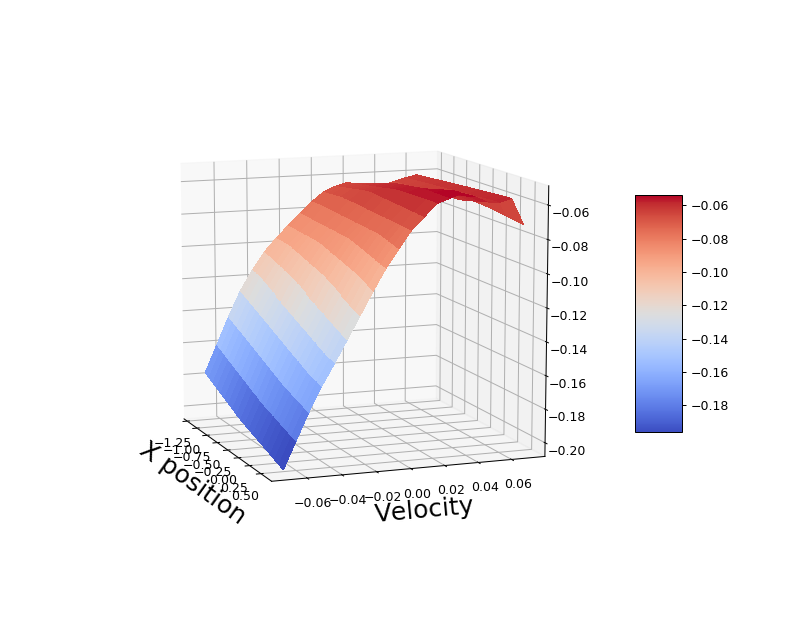

In [15]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')


# Make data
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], q_table.shape[0])
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], q_table.shape[1])
z = q_table


# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X position', fontsize=20)
ax.set_ylabel('Velocity', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)